# Agent-based model - Simulation and Results*
### *This code belongs to the paper "Assessing School-based Policy Actions for COVID-19: An Agent-Based Analysis of Incremental Infection Risk Associated with Airborne Transmission of SARS-CoV-2"

In [ ]:
from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql.types import *
import time
import pandas as pd
import numpy as np
import pyspark.sql.functions as f
from pyspark.sql.window import Window
import socket    
import random
from scipy import integrate
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import json 
import scipy as sc

hostname = socket.gethostname()    
IPAddr = socket.gethostbyname(hostname)  

conf = SparkConf().setAll([("spark.executor.instances", '5'), ('spark.executor.memory', '8g'), ('spark.executor.cores', '5'), ('spark.driver.memory','2g'),('spark.sql.broadcastTimeout', '3000')])
conf.setMaster('yarn')
conf.setAppName('spark-yarn-2')
conf.set("spark.driver.host", IPAddr)

pd.options.display.max_rows = 100

## Classes and Modules

In [ ]:
class Agent:
    
    
    
    def __init__ (self, agent_id = 0, gender = 0, stress_level = 0, resilience = 0, HEALTH_STATUS = 0, test_result = 'not_tested', class_presence = 0, prevalence_rate = 0, n = 1, time = 0):
        self.agent_id = agent_id
        self.gender = gender

        if (self.gender == 'Female')| (self.gender == 'female'):
            self.adherence_to_rules = 0.88
        elif (self.gender == 'Male') | (self.gender == 'male'):
            self.adherence_to_rules = 0.83
            
        if (stress_level == 'High') | (stress_level == 'high'):
            self.stress_level_impact = 0.6
        else:
            self.stress_level_impact = 1
            
        if (resilience == 'High') | (resilience == 'high'): #reduces 46% of stress
            self.resilience_impact = 0.54
        else:
            self.resilience_impact = 1    

        self.HEALTH_STATUS = HEALTH_STATUS
        if (self.HEALTH_STATUS == 'Asymptomatic') | (self.HEALTH_STATUS == 'asymptomatic') | (self.HEALTH_STATUS == 'Pre_symptomatic') | (self.HEALTH_STATUS == 'pre_symptomatic') | (self.HEALTH_STATUS == 'Mildly_symptomatic') | (self.HEALTH_STATUS == 'mildly_symptomatic') | (self.HEALTH_STATUS == 'Symptomatic') | (self.HEALTH_STATUS == 'symptomatic'):
            self.infection_status = 1
        else:
            self.infection_status = 0 #if exposed, infection_status will still be 0.
        self.test_result = test_result
        self.class_presence = class_presence
        self.prevalence_rate = prevalence_rate
        self.n = n
        self.incubation_period = np.random.normal(5.75, 5.75/3)
        self.latent_period = np.random.normal(2, 2/3)
        self.recovery_period = 14
        self.time = time
        self.log = pd.DataFrame({'time' : [], 'HEALTH_STATUS' : [], 'test_result' : []})
        
        
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------        
        
    def __repr__(self):
        return ('{}, {}, {}, {}, {}, {}'.format(self.agent_id, self.gender, self.stress_level_impact, self.resilience_impact, self.HEALTH_STATUS, self.class_presence))

    
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
              
        
    def add_agent_health_log(self, time):
        self.time = time
        logs = self.log
        
        if self.HEALTH_STATUS == 'Exposed':
            logs = logs[logs.HEALTH_STATUS == 'Exposed']
            if len(list(logs.time)) > 0:
                delta_time = list(logs.time)[-1] - list(logs.time)[0]
                if delta_time <= self.latent_period:
                    self.HEALTH_STATUS = 'Exposed'
                    self.infection_status = 0
                elif delta_time > self.latent_period:
                    self.HEALTH_STATUS = random.choices(['Asymptomatic','Pre_symptomatic'], k = 1, weights = [0.40,0.60])[0]  
                    self.infection_status = 1
                    
                    
        elif self.HEALTH_STATUS == 'Pre_symptomatic':
            logs = logs[logs.HEALTH_STATUS == 'Pre_symptomatic']
            if len(list(logs.time)) > 0:
                delta_time = list(logs.time)[-1] - list(logs.time)[0]
                if delta_time <= self.incubation_period - self.latent_period :
                    self.HEALTH_STATUS = 'Pre_symptomatic'
                    self.infection_status = 1
                elif delta_time > self.incubation_period - self.latent_period:
                    self.HEALTH_STATUS = random.choices(['Mildly_symptomatic', 'Symptomatic'], k = 1, weights = [0.81, 0.19])[0]  
                    self.infection_status = 1
        
        elif (self.HEALTH_STATUS == 'Mildly_symptomatic'):
            logs = logs[(logs.HEALTH_STATUS == 'Mildly_symptomatic')]
            if len(list(logs.time)) > 0:
                delta_time = list(logs.time)[-1] - list(logs.time)[0]
                if delta_time <= self.recovery_period :
                    self.HEALTH_STATUS = 'Mildly_symptomatic'
                    self.infection_status = 1
                elif delta_time > self.recovery_period:
                    self.HEALTH_STATUS = 'Immune'
                    self.infection_status = 0
                    
        elif (self.HEALTH_STATUS == 'Symptomatic'):
            logs = logs[(logs.HEALTH_STATUS == 'Symptomatic')]
            if len(list(logs.time)) > 0:
                delta_time = list(logs.time)[-1] - list(logs.time)[0]
                if delta_time <= self.recovery_period :
                    self.HEALTH_STATUS = 'Symptomatic'
                    self.infection_status = 1
                elif delta_time > self.recovery_period:
                    self.HEALTH_STATUS = random.choices(['Immune', 'Deceased'], k = 1, weights = [0.977, 0.023])[0]
                    self.infection_status = 0
                    
        elif self.HEALTH_STATUS == 'Asymptomatic':
            logs = logs[logs.HEALTH_STATUS == 'Asymptomatic']
            if len(list(logs.time)) > 0:
                delta_time = list(logs.time)[-1] - list(logs.time)[0]
                if delta_time <= self.recovery_period:
                    self.HEALTH_STATUS = 'Asymptomatic'
                    self.infection_status = 1
                elif delta_time > self.recovery_period:
                    self.HEALTH_STATUS = 'Immune'
                    self.infection_status = 0
                    
        new_row = {'time' : time, 'HEALTH_STATUS' : self.HEALTH_STATUS, 'test_result' : self.test_result}
        self.log = self.log.append(new_row, ignore_index=True)  
        

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    
    def update_agent_test_log(self, time, test_results_delay, test_accuracy): #if test_schedule _date == (current) time:
        self.time = time
        logs = self.log
        
        if self.test_result == 'Tested':
            logs = logs[logs.test_result == 'Tested']
            if len(list(logs.time)) > 0:
                delta_thing = len(list(logs.time))
                
                if np.mod(delta_thing, test_results_delay) != 0: #Still less than 2 days has passed from the test date
                    self.test_result = 'Tested'
                    
                elif np.mod(delta_thing, test_results_delay) == 0: #now let's ACTUALLY perform the test
                    u_prime = random.random()
                    if u_prime <= test_accuracy: 
                        if self.infection_status == 1:
                            self.test_result = 'Positive'
                        else:
                            self.test_result = 'Negative'
                    else:
                        self.test_result = 'Negative'
                        
            
        self.log.loc[self.log.time == time, 'test_result'] = self.test_result
    
    
#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
        
        
    
    def make_decision(self):
        if (self.HEALTH_STATUS == 'Asymptomatic') | (self.HEALTH_STATUS == 'asymptomatic') | (self.HEALTH_STATUS == 'Healthy') | (self.HEALTH_STATUS == 'healthy') | (self.HEALTH_STATUS == 'Pre_symptomatic') | (self.HEALTH_STATUS == 'pre_symptomatic') | (self.HEALTH_STATUS == 'Immune') | (self.HEALTH_STATUS == 'Exposed') :
            probability_of_showing_up = 1            
        elif (self.HEALTH_STATUS == 'Mildly_symptomatic') | (self.HEALTH_STATUS == 'mildly_symptomatic'):
            if (self.stress_level_impact == 0.6):
                probability_of_showing_up = (1 - self.adherence_to_rules) * (1 - self.stress_level_impact * self.resilience_impact)
            elif (self.stress_level_impact == 1):
                probability_of_showing_up = (1 - self.adherence_to_rules)
                
        elif (self.HEALTH_STATUS == 'Symptomatic') | (self.HEALTH_STATUS == 'symptomatic') | (self.HEALTH_STATUS == 'Deceased'):
             probability_of_showing_up = -1
        
        if (self.time == 0) & (self.agent_id == 1000 + self.n): #patient zero
            probability_of_showing_up = 1
                
        return(probability_of_showing_up) # 2%, 3% or 5%


#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------
    
    
    def create_students(self, prevalence_rate, n):
        students = []
        for i in range(n-1):
            student_id = 1000 + i
            gender = random.choices(['Male', 'Female'], k = 1, weights = [0.58, 0.42])[0]
            stress_level = random.choices(['high', 'low'], k = 1, weights = [0.5, 0.5])[0]
            resilience = random.choices(['high', 'low'], k = 1, weights = [0.5, 0.5])[0]
            #we assume that in the begining, half of the pre-symptomatic have already developed symptoms and half of them stil do not.
            HEALTH_STATUS = random.choices(['Healthy', 'Asymptomatic', 'Pre_symptomatic' , 'Mildly_symptomatic', 'Symptomatic'], k = 1, weights = [(1 - prevalence_rate), prevalence_rate*0.40, prevalence_rate*0.6*0.5, prevalence_rate*0.6*0.5*0.81, prevalence_rate*0.6*0.5*0.19])[0]           
            class_presence = -2
            if HEALTH_STATUS == 'Symptomatic': 
                test_result = 'Positive'
            else:
                test_result = 'Not_tested'                
            time = 0
            student = Agent(student_id, gender, stress_level, resilience, HEALTH_STATUS, test_result, class_presence, prevalence_rate, n, time)
            student.add_agent_health_log(time)
            students.append(student)
        
        #patient zero: the initial infectious agent
        student_id = 1000 + n
        gender = random.choices(['Male', 'Female'], k = 1, weights = [0.58, 0.42])[0]
        stress_level = random.choices(['high', 'low'], k = 1, weights = [0.5, 0.5])[0]
        resilience = random.choices(['high', 'low'], k = 1, weights = [0.5, 0.5])[0]
        HEALTH_STATUS = random.choices(['Asymptomatic', 'Pre_symptomatic' ], k = 1, weights = [0.40, 0.60])[0]           
        class_presence = -2
        time = 0
        
        the_initial_sick_student = Agent(student_id, gender, stress_level, resilience, HEALTH_STATUS, test_result, class_presence, prevalence_rate, n, time)
        the_initial_sick_student.add_agent_health_log(time)
        students.append(the_initial_sick_student)
        
        return(students)   
    

#-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------


    def create_teacher(self):
        teacher_id = 2
        gender = random.choices(['Male', 'Female'], k = 1, weights = [0.50, 0.50])[0]
        stress_level = random.choices(['high', 'low'], k = 1, weights = [0.5, 0.5])[0]
        resilience = random.choices(['high', 'low'], k = 1, weights = [0.5, 0.5])[0]
        HEALTH_STATUS = 'Healthy'
        class_presence = 2
        test_result = 'Not_tested'
        prevalence_rate = 0
        n = 1
        time = 0
        teacher = Agent(teacher_id, gender, stress_level, resilience, HEALTH_STATUS, test_result, class_presence, prevalence_rate, n, time)
        teacher.add_agent_health_log(time)
        return(teacher)

In [ ]:
class Classroom:
    
    def __init__ (self, students, teacher, rows, columns, prevalence_rate):
        self.students = students
        self.teacher = teacher
        self.n = len(students) 
        self.rows = rows
        self.columns = columns
        self.prevalence_rate = prevalence_rate
        
    def __repr__(self):
        return ('The class of "Classroom" returns the position matrix of classroom and students.')
    
    
    def get_classroom(self): 
        n = self.n
        rows = self.rows
        columns = self.columns
        students = self.students
        teacher = self.teacher
        teacher_positions = []
        for i in range(columns):
            teacher_positions.append(teacher)
        classroom_linear = []
        
        for student in students: #who will show up? who won't? (all healthy studetns will show up, though asymptomatics or Mildly_symptomatic should make a decision)
            u = random.random()
            if u <= student.make_decision():
                classroom_linear.append(student)
                student.class_presence = student.infection_status 
            else:
                student.class_presence = -1 
                
            if student.HEALTH_STATUS == 'Deceased':
                student.class_presence = -1 

            if student.test_result == 'Positive': # if test result are positive (false positive or true positive), they will NOT show up!
                student.class_presence = -1
                
            if (student.test_result == 'Tested') & (student.log.loc[student.log.test_result != 'Tested', 'test_result'].values[-1] == 'Positive'): 
                student.class_presence = -1
            
                
        n = len(classroom_linear)
        np.random.shuffle(classroom_linear)
        classroom_grid = np.zeros((rows+1, columns))
        classroom_linear = np.array(classroom_linear)
        if n > rows * columns:
            return(['ERROR: Number of students more than class capacity', 'ERROR: Number of students more than class capacity'])
        
        elif n == rows * columns:
            classroom_grid = classroom_linear.reshape((rows, columns))
            classroom_grid = np.vstack([teacher_positions, classroom_grid])

        elif n < rows * columns:
            empty_seats = []
            for i in range(rows * columns - n):
                empty_seats.append(Agent(-1, -1, -1, class_presence = -1))
            classroom_linear = np.append(classroom_linear, empty_seats)
            np.random.shuffle(classroom_linear)
            classroom_grid = classroom_linear.reshape((rows, columns))
            classroom_grid = np.vstack([teacher_positions, classroom_grid])
        
        classroom_scheme = np.zeros((rows + 1, columns))
        i = 0
        for row in classroom_grid:
            j = 0
            for column in row:
                if classroom_grid[i,j].class_presence == 1:
                    if classroom_grid[i,j].infection_status == 1:
                        classroom_scheme[i,j] = 1
                    else:
                        classroom_scheme[i,j] = 0
                elif classroom_grid[i,j].class_presence == -1:
                    classroom_scheme[i,j] = -1
                elif classroom_grid[i,j].class_presence == 2:
                    classroom_scheme[i,j] = 2
                j = j + 1
            i = i + 1
        return([classroom_grid, classroom_scheme])


In [ ]:
class Quanta_Cone:
    
    def __init__ (self, d, r, h, concentration_rate, itter_count):
        self.d = d
        self.r = r
        self.h = h
        self.concentration_rate = concentration_rate
        self.itter_count = itter_count
        
    def __repr__(self):
        return ('The class of "Quanta_Cone" returns the particle distribution of quanta made an infected person')
    
    def get_random_point(self):
        self.r = r
        self.h = h
        x = random.uniform(-r, r)
        y = random.uniform(-np.sqrt(np.power(r,2) - np.power(x,2)), np.sqrt(np.power(r,2) - np.power(x,2)))
        z = random.uniform((h/r)*np.sqrt(np.power(x,2) + np.power(y,2)), h)
        random_point_cone = [x, y, z]
        return (random_point_cone)
    
    def get_particle_ditribution(self):
        self.r = r
        self.h = h
        particle_ditribution = []
        for i in range(itter_count):
            point = self.get_random_point()
            particle_ditribution.append(point)
        return(particle_ditribution)
    
    def get_individual_distribution_matrix(self):
        self.r = r
        self.h = h
        self.d = d
        k_z = int(np.ceil((h-d/2)/d)+1)
        k_x = int((2*np.ceil((r-d/2)/d)) + 1)
        distribution_matrix = np.zeros((k_z, k_x))
        
        column = []
        i = 1
        for ross in distribution_matrix:  
            row = []
            for j in range(1, len(list(ross))+1):
                element = [[((-(k_x/2) + j - 1)*d), ((-(k_x/2) + j)*d)], [((k_z - i-1)*d + d/2), ((k_z - i)*d + d/2)]]
                row.append(element)
            column.append(row)
            i = i + 1
            
        distribution_matrix = np.array(column)
        return(distribution_matrix)
    
    def get_individual_quanta_proportion(self):
        particle_ditribution = self.get_particle_ditribution()
        distribution_matrix = self.get_individual_distribution_matrix()
        quanta_proportion = np.zeros((int(distribution_matrix.shape[0]), int(distribution_matrix.shape[1])))
        
        i = 0
        for row in distribution_matrix:
            j = 0
            for mini_matrix in row:
                x_range = mini_matrix[0]
                z_range = mini_matrix[1]
                count = 0
                for point in particle_ditribution:
                    if (x_range[0] <= point[0]) & (point[0] <= x_range[1]) & (z_range[0] <= point[2]) & (point[2] <= z_range[1]):
                        count = count + 1
                        
                quanta_proportion[i,j] = (count/itter_count)
                
                j = j +1
            i = i + 1  
        return (quanta_proportion)

In [ ]:
class Covid19_Spread:
    
    def __init__ (self, teacher, students, classroom_grid, quanta_proportion, d, ERq, IVRR, IR, n0, T, classroom_height, final_duration):
        self.teacher = teacher
        self.students = students
        self.classroom_grid = classroom_grid
        self.quanta_proportion = quanta_proportion
        self.d = d
        self.ERq = ERq
        self.IVRR = IVRR
        self.IR = IR
        self.n0 = n0
        self.T = T
        self.classroom_height = classroom_height
        self.final_duration = final_duration
        
    def __repr__(self):
        return ('The class of "Covid19_Spread" returns the matrix of infection rist for each studnet in the classroom')
    
    
    def get_total_quanta_matrix(self): #quanta DIRECTLY caused by infected students
        classroom_grid = self.classroom_grid
        quanta_proportion = self.quanta_proportion 
        ERq = self.ERq
        direct_quanta_matrix = np.zeros((int(classroom_grid.shape[0]), int(classroom_grid.shape[1])))
        infected_location = int(np.floor(quanta_proportion.shape[1]/2)) #where the infected person is lovated in the distribution matrix (column-var ;))        
        quanta_proportion[-1,infected_location] = 1000
        classroom_rows = classroom_grid.shape[0]
        classroom_columns = classroom_grid.shape[1]
        number_of_infected_s = 0
        
        for i in range(classroom_rows):
            for j in range(classroom_columns):
                if (classroom_grid[i, j].infection_status == 1) & (classroom_grid[i, j].class_presence == 1): # an infected STUDENT is in cell(i,j) of the classroom - it should NOT BE A TEACHER
                    number_of_infected_s = number_of_infected_s + 1
                    effective_area = classroom_grid[:i + 1, :] #رو به روی اون استودنت
                    
                    if  effective_area.shape[0] < quanta_proportion.shape[0]: #at the front of the student there is a wall so some of the particles will reflect
                        new_quanta_proportion = quanta_proportion[int(quanta_proportion.shape[0] - effective_area.shape[0]):, :]     
                    else:
                        new_quanta_proportion = quanta_proportion
                    if (j < infected_location) & ((classroom_columns-1) - j >= infected_location): #in the left side of the student there is a wall so some of the particles will reflect
                        new_quanta_proportion = new_quanta_proportion[:, (infected_location - j):]               
                    elif ((classroom_columns-1) - j < infected_location) & (j >= infected_location): #in the right side of the student there is a wall so some of the particles will reflect
                        new_quanta_proportion = new_quanta_proportion[:, : ((classroom_columns-1) - j) + infected_location + 1]
                    elif ((classroom_columns-1) - j < infected_location) & (j < infected_location): #Both walls
                        new_quanta_proportion = new_quanta_proportion[:, (infected_location - j):((classroom_columns-1) - j) + infected_location + 1]
                    else:
                        new_quanta_proportion = new_quanta_proportion
                        
                    infected_j = int(np.where(new_quanta_proportion == 1000)[1][0])
                    direct_quanta_matrix[(i - new_quanta_proportion.shape[0] + 1):i + 1, (j - infected_j):(j - infected_j) + int(new_quanta_proportion.shape[1])] = direct_quanta_matrix[(i - new_quanta_proportion.shape[0] + 1):i + 1, (j - infected_j):(j - infected_j) + int(new_quanta_proportion.shape[1])] + new_quanta_proportion
        
        direct_quanta_matrix = direct_quanta_matrix * ERq
        indirect_quanta_matrix = (1/(classroom_grid.shape[0]*classroom_grid.shape[1]))*np.ones((int(classroom_grid.shape[0]), int(classroom_grid.shape[1]))) * (number_of_infected_s * ERq)
        total_quanta_matrix = direct_quanta_matrix + indirect_quanta_matrix
        total_quanta_matrix[0, :] = sum(total_quanta_matrix[0, :]) #summation of all quanta for the teacher
        k = 0
        for row in classroom_grid:
            for p in (range(len(list(row)))):
                if (classroom_grid[k,p].infection_status == 1) | (classroom_grid[k,p].class_presence == -1) :
                    total_quanta_matrix[k,p] = 0.0  
            k = k + 1
        return([total_quanta_matrix, direct_quanta_matrix, indirect_quanta_matrix]) 
    
    
    def get_Wells_Riley_cumulative_risk(self): #quanta DIRECTLY caused by infected students
        classroom_grid = self.classroom_grid
        quanta_proportion = self.quanta_proportion 
        d = self.d
        ERq = self.ERq
        IVRR =  self.IVRR
        IR = self.IR
        n0 = self.n0
        T = self.T 
        classroom_height = self.classroom_height
        total_quanta_matrix = self.get_total_quanta_matrix()[0]
        t_range = np.arange(0, T+1, 1)     
        
        Wells_Riley_cumulative_risk = []
        Cu_Risk = []
        
        for ERq_I in total_quanta_matrix[0, :]:
            results = []
            V = int(classroom_grid.shape[1])*d*d*classroom_height
            def f(t):
                R = (ERq_I)/(IVRR*V) + (n0 + ERq_I/IVRR)*np.exp(-IVRR*t)/V
                return R
            for ttt in list(t_range):
                results.append(1 - np.exp(-IR*(integrate.quad(f,0,ttt/60)[0])))
            Cu_Risk.append(results)
        Wells_Riley_cumulative_risk.append(Cu_Risk)
        
        for row in total_quanta_matrix[1:, :]:
            Cu_Risk = []
            for ERq_I in row:
                results = []
                V = d*d*classroom_height
                def f(t):
                    R = (ERq_I)/(IVRR*V) + (n0 + ERq_I/IVRR)*np.exp(-IVRR*t)/V
                    return R
                for ttt in list(t_range):
                    results.append(1 - np.exp(-IR*(integrate.quad(f,0,ttt/60)[0])))
                Cu_Risk.append(results)
            Wells_Riley_cumulative_risk.append(Cu_Risk)
        Wells_Riley_cumulative_risk = np.array(Wells_Riley_cumulative_risk)    
        return(Wells_Riley_cumulative_risk)
    
    
    def get_final_Wells_Riley_risk(self):
        classroom_grid = self.classroom_grid
        quanta_proportion = self.quanta_proportion 
        d = self.d
        ERq = self.ERq
        IVRR =  self.IVRR
        IR = self.IR
        n0 = self.n0
        final_duration = self.final_duration 
        classroom_height = self.classroom_height
        total_quanta_matrix = self.get_total_quanta_matrix()[0]
        
        final_Wells_Riley_risk = []
        Cu_Risk = []
        
        for ERq_I in total_quanta_matrix[0, :]:
            V = int(classroom_grid.shape[1])*d*d*classroom_height
            def f(t):
                R = (ERq_I)/(IVRR*V) + (n0 + ERq_I/IVRR)*np.exp(-IVRR*t)/V
                return R
            Cu_Risk.append(1 - np.exp(-IR*(integrate.quad(f,0,final_duration/60)[0])))
        final_Wells_Riley_risk.append(Cu_Risk)
        
        for row in total_quanta_matrix[1:, :]:
            Cu_Risk = []
            for ERq_I in row:
                V = d*d*classroom_height
                def f(t):
                    R = (ERq_I)/(IVRR*V) + (n0 + ERq_I/IVRR)*np.exp(-IVRR*t)/V
                    return R
                Cu_Risk.append(1 - np.exp(-IR*(integrate.quad(f,0,final_duration/60)[0])))
            final_Wells_Riley_risk.append(Cu_Risk)
        final_Wells_Riley_risk = np.array(final_Wells_Riley_risk)    
        return(final_Wells_Riley_risk)
    
    

In [ ]:
class Simulation:
    
    def __init__ (self, students, teacher, classroom_grid, covid19_spread_model, time):
        self.covid19_spread_model = covid19_spread_model
        self.classroom_grid = classroom_grid
        self.time = time
        self.students = students
        self.teacher = teacher

    
    def simulate_one_session_of_the_class(self):
        final_Wells_Riley_risk = self.covid19_spread_model.get_final_Wells_Riley_risk()
        classroom_grid = self.covid19_spread_model.classroom_grid
        students = self.students
        teacher = self.teacher
        
        axis_0 = 0
        for row in final_Wells_Riley_risk:
            axis_1 = 0
            for risk in row:
                if classroom_grid[axis_0, axis_1].HEALTH_STATUS == 'Healthy': #make sure not to update health status for already infected agents
                    q_id = classroom_grid[axis_0, axis_1].agent_id
                    if teacher.agent_id == q_id:
                        teacher.HEALTH_STATUS = random.choices(['Healthy', 'Exposed'], k = 1, weights = [(1-risk), risk])[0]                                                                                
                    for i in range(len(students)):
                        if students[i].agent_id == q_id:
                            students[i].HEALTH_STATUS = random.choices(['Healthy', 'Exposed'], k = 1, weights = [(1-risk), risk])[0] 
                    
                axis_1 = axis_1 + 1
            axis_0 = axis_0 + 1
        teacher.time = time
        teacher.add_agent_health_log(time) 
        for s in students:
            s.time = time
            s.add_agent_health_log(time)
            
        return([teacher, students])       
    
    
#!!!!! ISSUE: The first test is ready in 24 hrs! the rest in 48 hrs!   
    def perform_surveillance_testing(self, time, sample_percentage = 0.1, test_accuracy = 0.90, test_results_delay = 2):
        
        classroom_grid = self.covid19_spread_model.classroom_grid
        students = self.students
        teacher = self.teacher
        
        #pick sample_percentage of the class
        for student in students: #A student might not be present in the class, yet be picked for a test
            if (student.test_result == 'Not_tested') | (student.test_result == 'Negative'):
                u = random.random()
                if u <= sample_percentage: #chosen to be tested
                    student.test_result = 'Tested'
            
            if (student.HEALTH_STATUS == 'Symptomatic') | (student.test_result == 'Positive'):
                student.test_result = 'Tested'
                
            student.update_agent_test_log(time, test_results_delay, test_accuracy) #OVERRIDE
        return([teacher, students])
            
        
    
    def perform_contact_tracing(self, time, contact_tracing_level = 0, test_accuracy = 0.9, test_results_delay = 2):
        
        classroom_grid = self.covid19_spread_model.classroom_grid
        students = self.students
        teacher = self.teacher                                    


        if (contact_tracing_level > 0):
            for student in students: #No need to test students who are already tested positive
                if (student.test_result == 'Not_tested') | (student.test_result == 'Negative'):
                    u = random.random()
                    if u <= contact_tracing_level: #chosen to be tested
                        student.test_result = 'Tested'

                student.update_agent_test_log(time, test_results_delay, test_accuracy) #OVERRIDE  
        
        return([teacher, students])
    
    
    
    def get_classroom_summary(self, time):
        students = self.students
        teacher = self.teacher
        
        number_of_infected_students = 0
        
        number_of_healthy_students = 0
        number_of_exposed_students = 0
        number_of_asymptomatic_students = 0
        number_of_presymptomatic_students = 0
        number_of_mildly_symptomatic_students = 0
        number_of_symptomatic_students = 0
        number_of_immune_students = 0
        number_of_deseased_students = 0
        
        teacher_status = teacher.HEALTH_STATUS
        
        for student in students:
            if student.HEALTH_STATUS == 'Healthy':
                number_of_healthy_students = number_of_healthy_students + 1
            elif student.HEALTH_STATUS == 'Exposed':
                number_of_exposed_students = number_of_exposed_students + 1
            elif student.HEALTH_STATUS == 'Asymptomatic':
                number_of_asymptomatic_students = number_of_asymptomatic_students + 1
            elif student.HEALTH_STATUS == 'Pre_symptomatic':
                number_of_presymptomatic_students = number_of_presymptomatic_students + 1
            elif student.HEALTH_STATUS == 'Mildly_symptomatic':
                number_of_mildly_symptomatic_students = number_of_mildly_symptomatic_students + 1
            elif student.HEALTH_STATUS == 'Symptomatic':
                number_of_symptomatic_students = number_of_symptomatic_students + 1
            elif student.HEALTH_STATUS == 'Immune':
                number_of_immune_students = number_of_immune_students + 1
            elif student.HEALTH_STATUS == 'Deceased':
                number_of_deseased_students = number_of_deseased_students + 1
                
        number_of_infected_students = number_of_asymptomatic_students + number_of_presymptomatic_students + number_of_mildly_symptomatic_students + number_of_symptomatic_students

        new_row = {'time': time, 'Healthy' : number_of_healthy_students, 'Exposed' : number_of_exposed_students, 'Asymptomatic' : number_of_asymptomatic_students, 'Pre_symptomatic' : number_of_presymptomatic_students,  'Mildly_symptomatic' : number_of_mildly_symptomatic_students,  'Symptomatic' : number_of_symptomatic_students,  'Immune' : number_of_immune_students,  'Deceased' : number_of_deseased_students, 'Teacher': teacher_status}
        return(new_row)  

In [ ]:
def traditional_Wells_Riley_risk(classroom_grid, rows, columns, d, classroom_height, ERq, IVRR, n0, T):
    I = 0
    for row in classroom_grid:
        for agent in row:
            if (agent.infection_status == 1) & (agent.class_presence == 1):#students who are infected
                I = I + 1

    V = (rows + 1)*columns*d*d*classroom_height #don't forget the teacher!

    def f(t):
        R = (ERq * I)/(IVRR*V) + (n0 + ERq * I/IVRR)*np.exp(-IVRR*t)/V
        return R

    results = []
    t_range = np.arange(0, T+1, 1) #in mins
    for ttt in list(t_range):
        results.append(1 - np.exp(-IR*(integrate.quad(f,0,ttt/60)[0])))       
        
    return results

## Simulation parameters

In [ ]:
n = 40
rows = 7
columns = 7
prevalence_rate = 0.017
d = 6/3.28084
r = 4/3.28084
h = 8/3.28084
concentration_rate = 0.95
itter_count = 10000
ERq = 120 * 0.3 # we assume agents are wearing double layer cloth masks so the quanta emissions rate is 70% less
IVRR = 1 + 0.24 + 0.63
IR = 0.9
n0 = 0
T = 180 #mins
classroom_height = 8/3.28084

final_duration = 120 # mins

sim_count = 100

gender = {'Female, Male'}
roommate = {0, 1, 2, 3, 4, 5, ...}
employment_status = {'???'}
adherence_to_rules = {'Women: 90%', 'Men: 85%'}
stress_level = {'high', 'Low'}
sleeping_quality = {'Good', 'Poor'}
resilience = {'high', 'Low'}
HEALTH_STATUS = { 'Healthy', 'Exposed','Asymptomatic', 'Pre_symptomatic', 'Mildly_symptomatic', 'Symptomatic', 'Deceased'}
test_results = {'Not_tested', 'Tested', 'Negative', 'Positive'}

sample_percentage = 0.10 #survaillence percentage
test_accuracy = 0.9
test_results_delay = 2
contact_tracing_levels = [0, 0.25, 0.50, 0.75, 1]
survailalnce_test_weekly_schedule = [1, 8, 15, 22, 29, 36, 43, 50, 57, 64, 71, 78, 85, 92, 99, 106, 113]

## Simulating one session of the class

In [ ]:
students = Agent().create_students(prevalence_rate, n)
teacher = Agent().create_teacher()
[classroom_grid, classroom_scheme] = Classroom(students, teacher, rows, columns, prevalence_rate).get_classroom()
quanta_proportion = Quanta_Cone(d, r, h, concentration_rate, itter_count).get_individual_quanta_proportion()

covid19_spread_model = Covid19_Spread(students, teacher, classroom_grid, quanta_proportion, d, ERq, IVRR, IR, n0, T, classroom_height, T)
Wells_Riley_cumulative_risk = covid19_spread_model.get_Wells_Riley_cumulative_risk()

results = traditional_Wells_Riley_risk(classroom_grid, rows, columns, d, classroom_height, ERq, IVRR, n0, T)

a = (covid19_spread_model.get_final_Wells_Riley_risk())

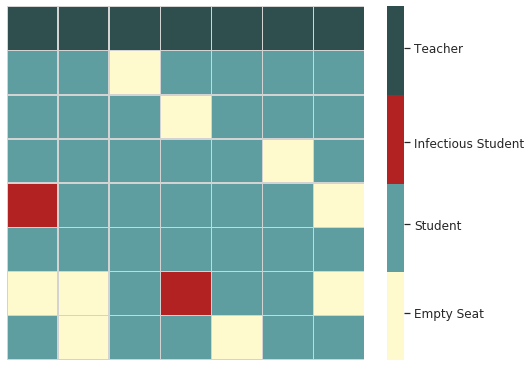

In [60]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

sns.set(rc={'figure.figsize':(8,6.5)})
sns.set(font_scale=1.1)


myColors = ('lemonchiffon', 'cadetblue', 'firebrick', 'darkslategray')
cmap = LinearSegmentedColormap.from_list('Custom', myColors, len(myColors))

ax = sns.heatmap(classroom_scheme, cmap=cmap, linewidths=.5, linecolor='lightgray')

# Manually specify colorbar labelling after it's been generated
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.6, 0.15, 0.85, 1.65])
colorbar.set_ticklabels(['Empty Seat', 'Student', 'Infectious Student', 'Teacher'])
ax.set(yticks=[], xticks = [])

# Only y-axis labels need their rotation set, x-axis labels already have a rotation of 0
_, labels = plt.yticks()
plt.setp(labels, rotation=0)
plt.savefig('plottt2-1.jpg', orientation="landscape",
           dpi=300)

plt.show()

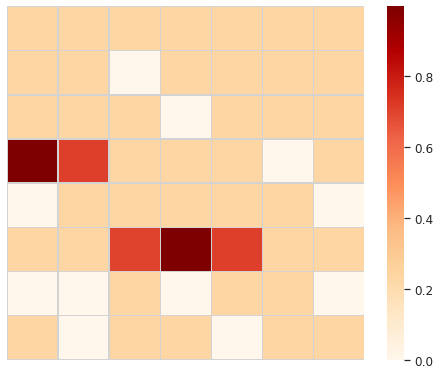

In [65]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

sns.set(rc={'figure.figsize':(8,6.5)})
sns.set(font_scale=1.1)

ax = sns.heatmap(a ,  cmap = 'OrRd', linewidths=.5, linecolor='lightgray')

ax.set(yticks=[], xticks = [])

plt.savefig('plottt2-2.jpg', orientation="landscape",
           dpi=300)
plt.show()

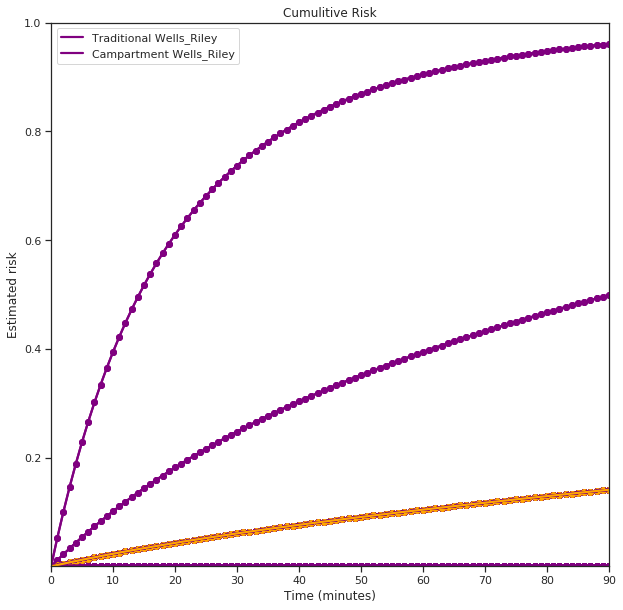

In [233]:
##### Now, Plotting the out!

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
fig, ax = plt.subplots(nrows=1, ncols=1, figsize = (10,10))

plt.title('Cumulitive Risk')

for item in Wells_Riley_cumulative_risk:
    for thing in item:
        
        plt.scatter(y = list(thing) , x = list(np.arange(0, T+1, 1)), color='purple', label='Campartment Wells_Riley') 
        plt.plot(list(np.arange(0, T+1, 1)) ,list(thing), color='purple', label='Campartment Wells_Riley') 

plt.scatter(y = list(results) , x = list(np.arange(0, T+1, 1)), color='orange', label='Traditional Wells_Riley') 
plt.plot(list(np.arange(0, T+1, 1)) ,list(results), color='orange', label='Traditional Wells_Riley') 

        #plt.scatter(y = list(Riley_diameter) , x = list(t_range), color='red') 
        #plt.plot(list(t_range) ,list(Riley_diameter), color='red', label='Diameter') 

        #plt.scatter(y = list(Riley_teacher) , x = list(t_range), color='orange') 

        #plt.plot(list(t_range) ,list(Riley_teacher), color='orange', label='Teacher') 
ax.set_ylim((0.0001,1))
ax.set_xlim((0,1.5*60))
ax.legend(['Traditional Wells_Riley','Campartment Wells_Riley'])
plt.xlabel('Time (minutes)')
plt.ylabel('Estimated risk')

plt.savefig('plot3.jpg', orientation="landscape",
           dpi=300)
plt.show()

## Simulating a class throughout the semester (120 days)

In [ ]:
contact_tracing_level = 0.5

students = Agent().create_students(prevalence_rate, n)
teacher = Agent().create_teacher()
quanta_proportion = Quanta_Cone(d, r, h, concentration_rate, itter_count).get_individual_quanta_proportion()

classroom_log = pd.DataFrame({'time': [], 'Healthy' : [], 'Exposed' : [],'Asymptomatic' : [], 'Pre_symptomatic' : [],  'Mildly_symptomatic' : [],  'Symptomatic' : [],  'Immune' : [],  'Deceased' : [], 'Teacher': []})

infected_student_ids = pd.DataFrame({'time' : [], 'Agent_ids' : []})
infected_student_ids = infected_student_ids.append({'time' : 0, 'Agent_ids' : []}, ignore_index=True)   #if the first time, contact tracing SHOULD happen. Hence, lets compare infected_ids with an empty set!

j = 0
for time in range(1,120): #simulate for 120 days    

    [classroom_grid, classroom_scheme] = Classroom(students, teacher, rows, columns, prevalence_rate).get_classroom()
    covid19_spread_model = Covid19_Spread(students, teacher, classroom_grid, quanta_proportion, d, ERq, IVRR, IR, n0, T, classroom_height, 50)
    replication = Simulation(students, teacher, classroom_grid, covid19_spread_model, time)
    
       
    if time in three_times_a_week_fourty_eight: #simulate for 90 days = the course of the semester
        replication.simulate_one_session_of_the_class() #this, will add students log automatically
        
        if j < len(survailalnce_test_weekly_schedule):
            if time == survailalnce_test_weekly_schedule[j]: #test happens on the same day as the class session

#Normal testing  
                replication.perform_surveillance_testing(time, sample_percentage, test_accuracy, test_results_delay)
#Contact tracing - part 1
                new_infected_list = []
                for student in students:
                    if student.test_result == 'Positive':
                        new_infected_list.append(student.agent_id)
                list_infected_students_id_now = infected_student_ids.loc[infected_student_ids.time == time - 1, 'Agent_ids'].values[0]  
                if (set(new_infected_list) != set(list_infected_students_id_now)):
                    if (set(list_infected_students_id_now) == set([])) | (set(new_infected_list).intersection(set(list_infected_students_id_now)) != set(new_infected_list)): 
                        replication.perform_contact_tracing(time, contact_tracing_level, test_accuracy, test_results_delay)                  
                    
                j = j + 1


    else: #simulate for 90 days = the course of the semester # if there is no class on that day, just update everything!
        for s in students: #Here, we update students log manually
            s.add_agent_health_log(time)
            s.update_agent_test_log(time, test_results_delay, test_accuracy)
        teacher.add_agent_health_log(time)
        #we do not test the teachers YET!
        
#Contact tracing - part 2
        new_infected_list = []
        for student in students:
            if student.test_result == 'Positive':
                new_infected_list.append(student.agent_id)
        list_infected_students_id_now = infected_student_ids.loc[infected_student_ids.time == time - 1, 'Agent_ids'].values[0]  
        if (set(new_infected_list) != set(list_infected_students_id_now)):
            if (set(list_infected_students_id_now) == set([])) | (set(new_infected_list).intersection(set(list_infected_students_id_now)) != set(new_infected_list)): 
                replication.perform_contact_tracing(time, contact_tracing_level, test_accuracy, test_results_delay)

            
    infected_student_ids = infected_student_ids.append({'time' : time, 'Agent_ids' : new_infected_list}, ignore_index=True)
    classroom_log = classroom_log.append(replication.get_classroom_summary(time), ignore_index=True)

In [ ]:
# Health Status of the students

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2) 

fig, axes = plt.subplots(nrows=5, ncols=8, figsize = (40,30))
i = 0
for axxx in axes:
    for ax in axxx:
        plt.title('HEALTH STATUS over time')
        ax.scatter(y = list(students[i].log.HEALTH_STATUS) , x = list(students[i].log.time), color='green', label='Campartment Wells_Riley') 
        ax.plot(list(students[i].log.time) ,list(students[i].log.HEALTH_STATUS), color='limegreen', label='Campartment Wells_Riley') 
        ax.set_xlabel('Duration (Days)')

        i = i + 1

In [ ]:
# Testing status of teh students 

import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.2) 

fig, axes = plt.subplots(nrows=5, ncols=8, figsize = (40,30))
i = 0
for axxx in axes:
    for ax in axxx:
        plt.title('test results over time')
        ax.scatter(y = list(students[i].log.test_result) , x = list(students[i].log.time), color='purple', label='Campartment Wells_Riley') 
        ax.plot(list(students[i].log.time) ,list(students[i].log.test_result), color='orchid', label='Campartment Wells_Riley') 
        ax.set_xlabel('Duration (Days)')

        i = i + 1

In [ ]:
# Epidemiological SIR-type plot

import seaborn as sns    

classroom_log_no_tea = classroom_log.drop('Teacher', axis = 1)

from matplotlib import rcParams

sns.set_context(rc={"lines.linewidth": 2.2})

df = classroom_log_no_tea.melt('time', var_name='HEALTH_STATUS',  value_name='Number of agents')
g = sns.relplot(x="time", y="Number of agents", hue='HEALTH_STATUS', data=df, height=8.27, aspect=11.7/8.27, kind = 'line')

## Simulating and comparing different class schedules throughout a semester (120 days)

In [12]:
once_a_week_sixteen = [1, 8, 15, 22, 29, 36, 43, 50, 57, 64, 71, 78, 85, 92, 99, 106, 113]
twice_a_week_2_5_thirty_two = [1, 3, 8, 10, 15, 17, 22, 24, 29, 31, 36, 38, 43, 45, 50, 52, 57, 59, 64, 66, 71, 73, 78, 80, 85, 87, 92, 94, 99, 101, 106, 107, 113]
twice_a_week_3_4_thirty_two = [1, 4, 8, 11, 15, 18, 22, 25, 29, 32, 36, 39, 43, 46, 50, 53, 57, 60, 64, 67, 71, 74, 78, 81, 85, 88, 92, 95, 99, 102, 106, 109, 113]
three_times_a_week_fourty_eight = [1, 3, 5, 8, 10, 12, 15, 17, 19, 22, 24, 26, 29, 31, 33, 36, 38, 40, 43, 45, 47, 49, 52, 54, 56, 59, 61, 64, 66, 68, 71, 73, 75, 78, 80, 82, 85, 87, 89, 92, 94, 96, 99, 101, 103, 106, 108, 110, 113]

Schedule_list = [[once_a_week_sixteen, 150], [twice_a_week_2_5_thirty_two, 75], [twice_a_week_3_4_thirty_two, 75], [three_times_a_week_fourty_eight, 50]]

In [113]:
# MEAN CUMULATIVE RISK
Test_and_trace_based_family = []
Test_and_trace_based_family_means = []

# 1- no testing


Final_MEAN_TRADITIONAL_RISKS = []
Final_MEAN_PROPOSED_RISK = []
Final_MEDIAN_PROPOSED_RISK = []
Final_MIN_PROPOSED_RISK = []
Final_MAX_PROPOSED_RISK = []

Final_MEAN_TRADITIONAL_RISKS_means = []
Final_MEAN_PROPOSED_RISK_means = []
Final_MEDIAN_PROPOSED_RISK_means = []
Final_MIN_PROPOSED_RISK_means = []
Final_MAX_PROPOSED_RISK_means = []

Final_STUDENTS_FINAL = []
Final_TEACHER_FINAL = []

Final_CLASS_ROOMS_LIST = []

for item in Schedule_list:
    
    schedule = item[0]
    final_duration = item[-1]
    
    STUDENTS_FINAL = []
    TEACHER_FINAL = []

    CLASS_ROOMS_LIST = []
    MEAN_TRADITIONAL_RISKS = []
    MEAN_PROPOSED_RISK = []
    MEDIAN_PROPOSED_RISK = []
    MIN_PROPOSED_RISK = []
    MAX_PROPOSED_RISK = []
    
    MEAN_TRADITIONAL_RISKS_means = []
    MEAN_PROPOSED_RISK_means = []
    MEDIAN_PROPOSED_RISK_means = []
    MIN_PROPOSED_RISK_means = []
    MAX_PROPOSED_RISK_means = []

    for i in range(sim_count):

        students = Agent().create_students(prevalence_rate, n)
        teacher = Agent().create_teacher()
        quanta_proportion = Quanta_Cone(d, r, h, concentration_rate, itter_count).get_individual_quanta_proportion()
        
        traditional_risks = []
        mean_proposed_risk = []
        median_proposed_risk = []
        min_proposed_risk = []
        max_proposed_risk = []
        
        classroom_log = pd.DataFrame({'time': [], 'Healthy' : [], 'Exposed' : [],'Asymptomatic' : [], 'Pre_symptomatic' : [],  'Mildly_symptomatic' : [],  'Symptomatic' : [],  'Immune' : [],  'Deceased' : [], 'Teacher': []})

        for time in range(1,120):
            
            [classroom_grid, classroom_scheme] = Classroom(students, teacher, rows, columns, prevalence_rate).get_classroom()
            covid19_spread_model = Covid19_Spread(students, teacher, classroom_grid, quanta_proportion, d, ERq, IVRR, IR, n0, T, classroom_height, final_duration)
            replication = Simulation(students, teacher, classroom_grid, covid19_spread_model, time)
            
            if time in schedule: #simulate for 90 days = the course of the semester
                replication.simulate_one_session_of_the_class() #this, will add students log automatically
                
                a = covid19_spread_model.get_final_Wells_Riley_risk()
                if len(list(a[np.nonzero(a)])) == 0: 
                    mean_proposed_risk.append(0)
                    median_proposed_risk.append(0)
                    min_proposed_risk.append(0)
                    max_proposed_risk.append(0)
                else:
                    mean_proposed_risk.append(np.mean(a[np.nonzero(a)]))
                    median_proposed_risk.append(np.median(a[np.nonzero(a)]))
                    min_proposed_risk.append(np.min(a[np.nonzero(a)]))
                    max_proposed_risk.append(np.max(a[np.nonzero(a)]))
                
                traditional_risks.append(traditional_Wells_Riley_risk(classroom_grid, rows, columns, d, classroom_height, ERq, IVRR, n0, final_duration)[-1]) 
                
            else: # if there is no class on that day, just update everything!
                for s in students: #Here, we update students log manually
                    s.add_agent_health_log(time)
                teacher.add_agent_health_log(time)
                #we do not test the teachers YET!

            #print(classroom_scheme)
            #print('\n')
            classroom_log = classroom_log.append(replication.get_classroom_summary(time), ignore_index=True)
                
        
        MEAN_TRADITIONAL_RISKS.append(traditional_risks)
        MEAN_PROPOSED_RISK.append(mean_proposed_risk)
        MEDIAN_PROPOSED_RISK.append(median_proposed_risk)
        MIN_PROPOSED_RISK.append(min_proposed_risk)
        MAX_PROPOSED_RISK.append(max_proposed_risk)
        
        MEAN_TRADITIONAL_RISKS_means.append(np.nanmean(traditional_risks))
        MEAN_PROPOSED_RISK_means.append(np.nanmean(mean_proposed_risk))
        MEDIAN_PROPOSED_RISK_means.append(np.nanmean(median_proposed_risk))
        MIN_PROPOSED_RISK_means.append(np.nanmean(min_proposed_risk))
        MAX_PROPOSED_RISK_means.append(np.nanmean(max_proposed_risk))
                                          
        CLASS_ROOMS_LIST.append(classroom_log)

        ss_total = []
        for student in students:      
            ss_total.append(student)
        STUDENTS_FINAL.append(ss_total)
        TEACHER_FINAL.append(teacher)
    
    Final_MEAN_TRADITIONAL_RISKS.append(MEAN_TRADITIONAL_RISKS)
    Final_MEAN_PROPOSED_RISK.append(MEAN_PROPOSED_RISK)
    Final_MEDIAN_PROPOSED_RISK.append(MEDIAN_PROPOSED_RISK) 
    Final_MIN_PROPOSED_RISK.append(MIN_PROPOSED_RISK) 
    Final_MAX_PROPOSED_RISK.append(MAX_PROPOSED_RISK) 
    
    Final_MEAN_TRADITIONAL_RISKS_means.append(MEAN_TRADITIONAL_RISKS_means)
    Final_MEAN_PROPOSED_RISK_means.append(MEAN_PROPOSED_RISK_means)
    Final_MEDIAN_PROPOSED_RISK_means.append(MEDIAN_PROPOSED_RISK_means)
    Final_MIN_PROPOSED_RISK_means.append(MIN_PROPOSED_RISK_means) 
    Final_MAX_PROPOSED_RISK_means.append(MAX_PROPOSED_RISK_means) 
    
    Final_STUDENTS_FINAL.append(STUDENTS_FINAL)
    Final_TEACHER_FINAL.append(TEACHER_FINAL)

    Final_CLASS_ROOMS_LIST.append(CLASS_ROOMS_LIST)
    
    

Test_and_trace_based_family.append([Final_MEAN_TRADITIONAL_RISKS, Final_MEAN_PROPOSED_RISK, Final_STUDENTS_FINAL, Final_TEACHER_FINAL, Final_CLASS_ROOMS_LIST, Final_MEDIAN_PROPOSED_RISK, Final_MIN_PROPOSED_RISK, Final_MAX_PROPOSED_RISK])
Test_and_trace_based_family_means.append([Final_MEAN_TRADITIONAL_RISKS_means, Final_MEAN_PROPOSED_RISK_means, Final_STUDENTS_FINAL, Final_TEACHER_FINAL, Final_CLASS_ROOMS_LIST, Final_MEDIAN_PROPOSED_RISK_means, Final_MIN_PROPOSED_RISK_means, Final_MAX_PROPOSED_RISK_means])



# 2- testing + different contact_tracing_levels
for contact_tracing_level in [0, 0.25, 0.50, 0.75, 1]:
    

    Final_MEAN_TRADITIONAL_RISKS = []
    Final_MEAN_PROPOSED_RISK = []
    Final_MEDIAN_PROPOSED_RISK = []
    Final_MIN_PROPOSED_RISK = []
    Final_MAX_PROPOSED_RISK = []
    
    Final_MEAN_TRADITIONAL_RISKS_means = []
    Final_MEAN_PROPOSED_RISK_means = []
    Final_MEDIAN_PROPOSED_RISK_means = []
    Final_MIN_PROPOSED_RISK_means = []
    Final_MAX_PROPOSED_RISK_means = []

    Final_STUDENTS_FINAL = []
    Final_TEACHER_FINAL = []

    Final_CLASS_ROOMS_LIST = []

    for item in Schedule_list:

        schedule = item[0]
        final_duration = item[-1]

        STUDENTS_FINAL = []
        TEACHER_FINAL = []

        CLASS_ROOMS_LIST = []
        MEAN_TRADITIONAL_RISKS = []
        MEAN_PROPOSED_RISK = []
        MEDIAN_PROPOSED_RISK = []
        MIN_PROPOSED_RISK = []
        MAX_PROPOSED_RISK = []

        MEAN_TRADITIONAL_RISKS_means = []
        MEAN_PROPOSED_RISK_means = []
        MEDIAN_PROPOSED_RISK_means = []
        MIN_PROPOSED_RISK_means = []
        MAX_PROPOSED_RISK_means = []
    
        for i in range(sim_count):

            students = Agent().create_students(prevalence_rate, n)
            teacher = Agent().create_teacher()
            quanta_proportion = Quanta_Cone(d, r, h, concentration_rate, itter_count).get_individual_quanta_proportion()
            
            traditional_risks = []
            mean_proposed_risk = []
            median_proposed_risk = []
            min_proposed_risk = []
            max_proposed_risk = []

            classroom_log = pd.DataFrame({'time': [], 'Healthy' : [], 'Exposed' : [],'Asymptomatic' : [], 'Pre_symptomatic' : [],  'Mildly_symptomatic' : [],  'Symptomatic' : [],  'Immune' : [],  'Deceased' : [], 'Teacher': []})
            infected_student_ids = pd.DataFrame({'time' : [], 'Agent_ids' : []})
            infected_student_ids = infected_student_ids.append({'time' : 0, 'Agent_ids' : []}, ignore_index=True)   #if the first time, contact tracing SHOULD happen. Hence, lets compare infected_ids with an empty set!

            j = 0
            for time in range(1,120):
                
                [classroom_grid, classroom_scheme] = Classroom(students, teacher, rows, columns, prevalence_rate).get_classroom()
                covid19_spread_model = Covid19_Spread(students, teacher, classroom_grid, quanta_proportion, d, ERq, IVRR, IR, n0, T, classroom_height, final_duration)
                replication = Simulation(students, teacher, classroom_grid, covid19_spread_model, time)
            
                if time in schedule: #simulate for the course of the semester
                    replication.simulate_one_session_of_the_class() #this, will add students log automatically
                    
                    
                    a = covid19_spread_model.get_final_Wells_Riley_risk()
                    if len(list(a[np.nonzero(a)])) == 0: 
                        mean_proposed_risk.append(0)
                        median_proposed_risk.append(0)
                        min_proposed_risk.append(0)
                        max_proposed_risk.append(0)
                    else:
                        mean_proposed_risk.append(np.mean(a[np.nonzero(a)]))
                        median_proposed_risk.append(np.median(a[np.nonzero(a)]))
                        min_proposed_risk.append(np.min(a[np.nonzero(a)]))
                        max_proposed_risk.append(np.max(a[np.nonzero(a)]))

                    traditional_risks.append(traditional_Wells_Riley_risk(classroom_grid, rows, columns, d, classroom_height, ERq, IVRR, n0, final_duration)[-1]) 

                    
                    
                    if j < len(survailalnce_test_weekly_schedule):
                        if time == survailalnce_test_weekly_schedule[j]: #test happens on the same day as the class session

            #Normal testing  
                            replication.perform_surveillance_testing(time, sample_percentage, test_accuracy, test_results_delay)
            #Contact tracing - part 1
                            new_infected_list = []
                            for student in students:
                                if student.test_result == 'Positive':
                                    new_infected_list.append(student.agent_id)
                            list_infected_students_id_now = infected_student_ids.loc[infected_student_ids.time == time - 1, 'Agent_ids'].values[0]  
                            if (set(new_infected_list) != set(list_infected_students_id_now)):
                                if (set(list_infected_students_id_now) == set([])) | (set(new_infected_list).intersection(set(list_infected_students_id_now)) != set(new_infected_list)): 
                                    replication.perform_contact_tracing(time, contact_tracing_level, test_accuracy, test_results_delay)                  

                            j = j + 1


                else: #simulate for 90 days = the course of the semester # if there is no class on that day, just update everything!
                    for s in students: #Here, we update students log manually
                        s.add_agent_health_log(time)
                        s.update_agent_test_log(time, test_results_delay, test_accuracy)
                    teacher.add_agent_health_log(time)
                    #we do not test the teachers YET!

            #Contact tracing - part 2
                    new_infected_list = []
                    for student in students:
                        if student.test_result == 'Positive':
                            new_infected_list.append(student.agent_id)
                    list_infected_students_id_now = infected_student_ids.loc[infected_student_ids.time == time - 1, 'Agent_ids'].values[0]  
                    if (set(new_infected_list) != set(list_infected_students_id_now)):
                        if (set(list_infected_students_id_now) == set([])) | (set(new_infected_list).intersection(set(list_infected_students_id_now)) != set(new_infected_list)): 
                            replication.perform_contact_tracing(time, contact_tracing_level, test_accuracy, test_results_delay)

                
                infected_student_ids = infected_student_ids.append({'time' : time, 'Agent_ids' : new_infected_list}, ignore_index=True)
                classroom_log = classroom_log.append(replication.get_classroom_summary(time), ignore_index=True)

                
            MEAN_TRADITIONAL_RISKS.append(traditional_risks)
            MEAN_PROPOSED_RISK.append(mean_proposed_risk)
            MEDIAN_PROPOSED_RISK.append(median_proposed_risk)
            MIN_PROPOSED_RISK.append(min_proposed_risk)
            MAX_PROPOSED_RISK.append(max_proposed_risk)
            
            MEAN_TRADITIONAL_RISKS_means.append(np.nanmean(traditional_risks))
            MEAN_PROPOSED_RISK_means.append(np.nanmean(mean_proposed_risk))
            MEDIAN_PROPOSED_RISK_means.append(np.nanmean(median_proposed_risk))
            MIN_PROPOSED_RISK_means.append(np.nanmean(min_proposed_risk))
            MAX_PROPOSED_RISK_means.append(np.nanmean(max_proposed_risk))
                                              
            CLASS_ROOMS_LIST.append(classroom_log)

            ss_total = []
            for student in students:      
                ss_total.append(student)
            STUDENTS_FINAL.append(ss_total)
            TEACHER_FINAL.append(teacher)

        Final_MEAN_TRADITIONAL_RISKS.append(MEAN_TRADITIONAL_RISKS)
        Final_MEAN_PROPOSED_RISK.append(MEAN_PROPOSED_RISK)
        Final_MEDIAN_PROPOSED_RISK.append(MEDIAN_PROPOSED_RISK)
        Final_MIN_PROPOSED_RISK.append(MIN_PROPOSED_RISK) 
        Final_MAX_PROPOSED_RISK.append(MAX_PROPOSED_RISK) 

        Final_MEAN_TRADITIONAL_RISKS_means.append(MEAN_TRADITIONAL_RISKS_means)
        Final_MEAN_PROPOSED_RISK_means.append(MEAN_PROPOSED_RISK_means)
        Final_MEDIAN_PROPOSED_RISK_means.append(MEDIAN_PROPOSED_RISK_means)
        Final_MIN_PROPOSED_RISK_means.append(MIN_PROPOSED_RISK_means) 
        Final_MAX_PROPOSED_RISK_means.append(MAX_PROPOSED_RISK_means) 
        
        Final_STUDENTS_FINAL.append(STUDENTS_FINAL)
        Final_TEACHER_FINAL.append(TEACHER_FINAL)

        Final_CLASS_ROOMS_LIST.append(CLASS_ROOMS_LIST)


    Test_and_trace_based_family.append([Final_MEAN_TRADITIONAL_RISKS, Final_MEAN_PROPOSED_RISK, Final_STUDENTS_FINAL, Final_TEACHER_FINAL, Final_CLASS_ROOMS_LIST, Final_MEDIAN_PROPOSED_RISK, Final_MIN_PROPOSED_RISK, Final_MAX_PROPOSED_RISK])
    Test_and_trace_based_family_means.append([Final_MEAN_TRADITIONAL_RISKS_means, Final_MEAN_PROPOSED_RISK_means, Final_STUDENTS_FINAL, Final_TEACHER_FINAL, Final_CLASS_ROOMS_LIST, Final_MEDIAN_PROPOSED_RISK_means, Final_MIN_PROPOSED_RISK_means, Final_MAX_PROPOSED_RISK_means])


### Saving the data

In [137]:
import pickle

with open("Test_and_trace_based_family.txt", "wb") as fp:   #Pickling
    pickle.dump(Test_and_trace_based_family, fp)
    
with open("Test_and_trace_based_family_means.txt", "wb") as fp:   #Pickling
    pickle.dump(Test_and_trace_based_family_means, fp)   


In [13]:
import pickle

with open("Test_and_trace_based_family.txt", "rb") as fp:   # Unpickling
    Test_and_trace_based_family = pickle.load(fp)


with open("Test_and_trace_based_family_means.txt", "rb") as fp:   # Unpickling
    Test_and_trace_based_family_means = pickle.load(fp)

### Analysis of the traditional Wells Riley risk and mean proposed method risk for each session of the class

In [14]:
# Creating the dataset
models = ['No Testing', 'Testing without contact tracing', 'Cotact tracing level = 25%', 'Cotact tracing level = 50%', 'Cotact tracing level = 75%', 'Cotact tracing level = 100%']
duration_based_data_FULL = pd.DataFrame({'Schedule': [], 'Estimated risk' : [], 'Model type' : [], 'Test type' : []})

j = 0
for model in Test_and_trace_based_family:
    Final_MEAN_TRADITIONAL_RISKS = model[0]
    Final_MEAN_PROPOSED_RISK = model[1]
    Final_MEDIAN_PROPOSED_RISK = model[5]
    Final_MIN_PROPOSED_RISK = model[6]
    Final_MAX_PROPOSED_RISK = model[7]
    
    x = ['1' for i in range(sim_count*5)] + ['(2-5)' for i in range(sim_count*5)] + ['(3-4)' for i in range(sim_count*5)] + ['3' for i in range(sim_count*5)]
    y = Final_MEAN_TRADITIONAL_RISKS[0] + Final_MEAN_PROPOSED_RISK[0] + Final_MEDIAN_PROPOSED_RISK[0] + Final_MIN_PROPOSED_RISK[0] + Final_MAX_PROPOSED_RISK[0] + Final_MEAN_TRADITIONAL_RISKS[1] + Final_MEAN_PROPOSED_RISK[1] + Final_MEDIAN_PROPOSED_RISK[1] + Final_MIN_PROPOSED_RISK[1] + Final_MAX_PROPOSED_RISK[1] + Final_MEAN_TRADITIONAL_RISKS[2] + Final_MEAN_PROPOSED_RISK[2] + Final_MEDIAN_PROPOSED_RISK[2] + Final_MIN_PROPOSED_RISK[2] + Final_MAX_PROPOSED_RISK[2] +  Final_MEAN_TRADITIONAL_RISKS[3] + Final_MEAN_PROPOSED_RISK[3] + Final_MEDIAN_PROPOSED_RISK[3] + Final_MIN_PROPOSED_RISK[3] + Final_MAX_PROPOSED_RISK[3] 
    z = (['Mean - Traditional model' for i in range(sim_count)] + ['Mean - Proposed Model' for i in range(sim_count)] + ['Midian- Proposed Model' for i in range(sim_count)] + ['Min- Proposed Model' for i in range(sim_count)] + ['Max- Proposed Model' for i in range(sim_count)])*4
    q = [models[j] for i in range(sim_count)]*20 
    duration_based_data_FULL = pd.concat([duration_based_data_FULL, pd.DataFrame({'Schedule': x, 'Estimated risk' : y, 'Model type' : z, 'Test type': q})])
    j = j + 1

    
duration_based_data_FULL = duration_based_data_FULL.reset_index()
duration_based_data_FULL = duration_based_data_FULL.drop(columns=duration_based_data_FULL.columns[0])

In [124]:
duration_based_data_FULL.to_csv('duration_based_data_FULL_listic.csv')

In [118]:
import json 
import matplotlib.pyplot as plt

#Cotact tracing level = 100%
ttt = 17 #(0 to 16)

duration_based_data_FULL_once = duration_based_data_FULL[duration_based_data_FULL['Schedule'] == '1']
duration_based_data_FULL_once_no_testing = duration_based_data_FULL_once[duration_based_data_FULL_once['Test type'] == 'Cotact tracing level = 100%']
duration_based_data_FULL_once_no_testing = duration_based_data_FULL_once_no_testing.reset_index()


time_series = []
time_index = []
model_type = []
i = 0
for item in list(duration_based_data_FULL_once_no_testing['Estimated risk']):
#    item = json.loads(item) 
    time_series = time_series + item
    time_index = time_index + list(range(ttt))
    model_type = model_type + [duration_based_data_FULL_once_no_testing['Model type'][i] for j in range(ttt)]
    i = i + 1
    
melted_df = pd.DataFrame({'Time':time_index, 'Estimated risk':time_series, 'Model type': model_type})

In [ ]:
import seaborn as sns    

g = sns.relplot(x="Time", y="Estimated risk", hue='Model type', data=melted_df, height=8.27, aspect=11.7/8.27, kind = 'line')
plt.title('No Testing - Once a week class - Throughout the semester')

In [ ]:
import seaborn as sns    

g = sns.relplot(x="Time", y="Estimated risk", hue='Model type', data=melted_df, height=8.27, aspect=11.7/8.27, kind = 'line')
plt.title('Contact tracing level = 100% - Once a week class - Throughout the semester')

### Analysis of the mean traditional Wells Riley risk and mean proposed method risk throughout the semester

In [16]:
# Creating the dataset
models = ['No Testing', 'Testing without contact tracing', 'Contact tracing level = 25%', 'Contact tracing level = 50%', 'Contact tracing level = 75%', 'Contact tracing level = 100%']
duration_based_data_FULL = pd.DataFrame({'Schedule': [], 'Estimated risk' : [], 'Model type' : [], 'Test type' : []})

j = 0
for model in Test_and_trace_based_family_means:
    Final_MEAN_TRADITIONAL_RISKS = model[0]
    Final_MEAN_PROPOSED_RISK = model[1]
    Final_MEDIAN_PROPOSED_RISK = model[5]
    Final_MIN_PROPOSED_RISK = model[6]
    Final_MAX_PROPOSED_RISK = model[7]
    
    x = ['1' for i in range(sim_count*5)] + ['(2-5)' for i in range(sim_count*5)] + ['(3-4)' for i in range(sim_count*5)] + ['3' for i in range(sim_count*5)]
    y = Final_MEAN_TRADITIONAL_RISKS[0] + Final_MEAN_PROPOSED_RISK[0] + Final_MEDIAN_PROPOSED_RISK[0] + Final_MIN_PROPOSED_RISK[0] + Final_MAX_PROPOSED_RISK[0] + Final_MEAN_TRADITIONAL_RISKS[1] + Final_MEAN_PROPOSED_RISK[1] + Final_MEDIAN_PROPOSED_RISK[1] + Final_MIN_PROPOSED_RISK[1] + Final_MAX_PROPOSED_RISK[1] + Final_MEAN_TRADITIONAL_RISKS[2] + Final_MEAN_PROPOSED_RISK[2] + Final_MEDIAN_PROPOSED_RISK[2] + Final_MIN_PROPOSED_RISK[2] + Final_MAX_PROPOSED_RISK[2] +  Final_MEAN_TRADITIONAL_RISKS[3] + Final_MEAN_PROPOSED_RISK[3] + Final_MEDIAN_PROPOSED_RISK[3] + Final_MIN_PROPOSED_RISK[3] + Final_MAX_PROPOSED_RISK[3] 
    z = (['Mean - Traditional model' for i in range(sim_count)] + ['Mean - Proposed Model' for i in range(sim_count)] + ['Midian- Proposed Model' for i in range(sim_count)] + ['Min- Proposed Model' for i in range(sim_count)] + ['Max- Proposed Model' for i in range(sim_count)])*4
    q = [models[j] for i in range(sim_count)]*20 
    duration_based_data_FULL = pd.concat([duration_based_data_FULL, pd.DataFrame({'Schedule': x, 'Estimated risk' : y, 'Model type' : z, 'Test type': q})])
    j = j + 1

    
duration_based_data_FULL = duration_based_data_FULL.reset_index()
duration_based_data_FULL = duration_based_data_FULL.drop(columns=duration_based_data_FULL.columns[0])


In [126]:
duration_based_data_FULL.to_csv('duration_based_data_FULL.csv')

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
sns.set(rc={'figure.figsize':(13,17)})

sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

g = sns.FacetGrid(duration_based_data_FULL, col = "Test type", height=5, aspect=1.5 , col_wrap=3)
g.map_dataframe(sns.violinplot, x = "Schedule", y = "Estimated risk", hue = "Model type", palette=["coral", "lightseagreen", "yellowgreen", "lightgreen", "green"])
g.add_legend()
#sns.violinplot(x = "Schedule", y = "Estimated risk", data = duration_based_data_FULL, palette=["salmon", "mediumturquoise"], split = True);
#reyplot.set(ylim=(0, 1))
plt.show()

/opt/conda/lib/python3.7/site-packages/seaborn/axisgrid.py:330: UserWarning: `gridspec_kws` ignored when using `col_wrap`
  warnings.warn("`gridspec_kws` ignored when using `col_wrap`")


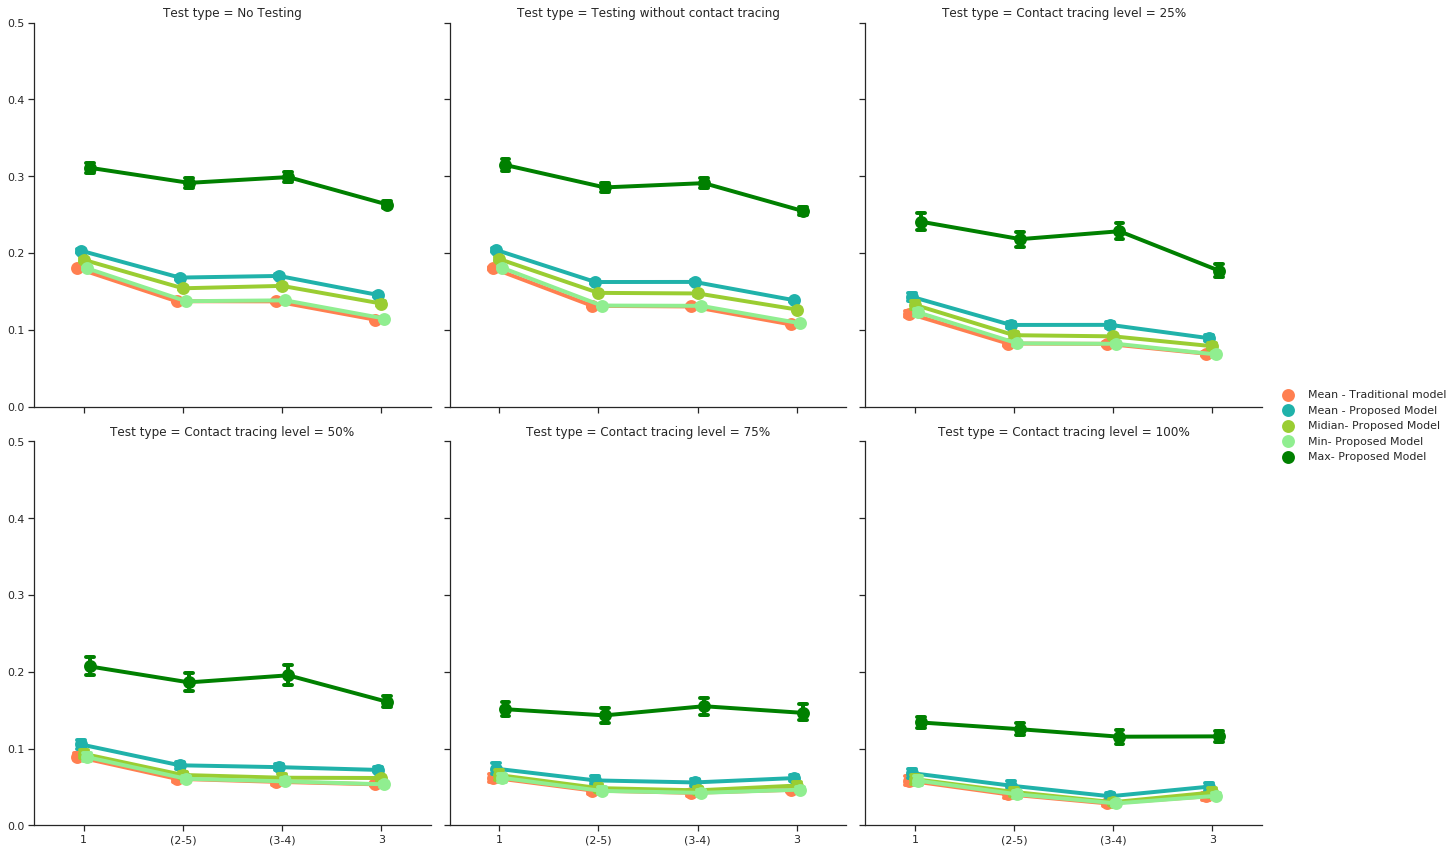

In [278]:
from matplotlib import rcParams

# figure size in inches
rcParams['figure.figsize'] = 10,2

sns.set()
sns.set_context(rc={"lines.linewidth": 2.2})

sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})

g = sns.FacetGrid(duration_based_data_FULL, col = "Test type", height=6, aspect=1, col_wrap=3, gridspec_kws={"wspace":0.7})
g.map_dataframe(sns.pointplot, x = "Schedule", y = "Estimated risk", hue = "Model type", palette=["coral", "lightseagreen", "yellowgreen", "lightgreen", "green"], dodge=True, length = 3, capsize=0.08)
g.add_legend()
g.set(ylim=(0, 0.5))
plt.savefig('plot4.jpg', orientation="landscape",
           dpi=300)

### Performing tests of statistical significance

In [19]:
import scipy as sc

t_test_independent_results = pd.DataFrame({'Test_type' : [], 'Comparison between' : [],'Change in estimated risk (%)' : [],'P_Value' : []})
for item in models:

    duration_based_data_FULL_proposed = duration_based_data_FULL[(duration_based_data_FULL['Model type'] == 'Mean - Proposed Model')]

    duration_based_data_FULL_proposed_1 = duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '1' )]['Estimated risk'] 
    duration_based_data_FULL_proposed_2_5 = duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '(2-5)' )]['Estimated risk'] 
    duration_based_data_FULL_proposed_3_4 = duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '(3-4)' )]['Estimated risk'] 
    duration_based_data_FULL_proposed_3 = duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '3' )]['Estimated risk'] 

    risk_difference_1 = np.nanmean(duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '1' )]['Estimated risk']) 
    risk_difference_2_5 = np.nanmean(duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '(2-5)' )]['Estimated risk'])
    risk_difference_3_4 = np.nanmean(duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '(3-4)' )]['Estimated risk'])
    risk_difference_3 = np.nanmean(duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '3' )]['Estimated risk'])
    
    t_test_independent_results = t_test_independent_results.append({'Test_type' : item, 'Comparison between' : '1 & (2-5)', 'Change in estimated risk (%)' : 100*(risk_difference_2_5 - risk_difference_1)/risk_difference_1, 'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_1,duration_based_data_FULL_proposed_2_5)[1]}, ignore_index=True)
    t_test_independent_results = t_test_independent_results.append({'Test_type' : item, 'Comparison between' : '1 & (3-4)', 'Change in estimated risk (%)' : 100*(risk_difference_3_4 - risk_difference_1)/risk_difference_1,'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_1,duration_based_data_FULL_proposed_3_4)[1]}, ignore_index=True)
    t_test_independent_results = t_test_independent_results.append({'Test_type' : item, 'Comparison between' : '1 & 3', 'Change in estimated risk (%)' : 100*(risk_difference_3 - risk_difference_1)/risk_difference_1, 'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_1,duration_based_data_FULL_proposed_3)[1]}, ignore_index=True)
    t_test_independent_results = t_test_independent_results.append({'Test_type' : item, 'Comparison between' : '(2-5) & (3-4)', 'Change in estimated risk (%)' : 100*(risk_difference_3_4 - risk_difference_2_5)/risk_difference_2_5, 'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_2_5,duration_based_data_FULL_proposed_3_4)[1]}, ignore_index=True)
    t_test_independent_results = t_test_independent_results.append({'Test_type' : item, 'Comparison between' : '(2-5) & 3', 'Change in estimated risk (%)' : 100*(risk_difference_3 - risk_difference_2_5)/risk_difference_2_5,'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_2_5,duration_based_data_FULL_proposed_3)[1]}, ignore_index=True)
    t_test_independent_results = t_test_independent_results.append({'Test_type' : item, 'Comparison between' : '(3-4) & 3', 'Change in estimated risk (%)' : 100*(risk_difference_3 - risk_difference_3_4)/risk_difference_3_4, 'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_3_4,duration_based_data_FULL_proposed_3)[1]}, ignore_index=True)

In [21]:
t_test_independent_results.to_csv('t_test_independent_results_latest_percent.csv')

In [22]:
# contact tracing levels - for 3-days-per-week schedule

import scipy as sc

lislis = []
t_test_independent_results_case_based = pd.DataFrame({'Test_type' : [] ,'Change in estimated risk (%)' : [],'P_Value' : []})
for item in models:

    duration_based_data_FULL_proposed = duration_based_data_FULL[(duration_based_data_FULL['Model type'] == 'Mean - Proposed Model')]

    duration_based_data_FULL_proposed_3 = duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '3' )]['Estimated risk'] 

    risk_difference_3 = np.nanmean(duration_based_data_FULL_proposed[(duration_based_data_FULL_proposed['Test type'] == item ) & (duration_based_data_FULL_proposed['Schedule'] == '3' )]['Estimated risk'])
    
    lislis.append([risk_difference_3])

t_test_independent_results_case_based = t_test_independent_results_case_based.append({'Test_type' : item, 'Comparison between' : '1 & (2-5)', 'Change in estimated risk (%)' : 100*(risk_difference_2_5 - risk_difference_1)/risk_difference_1, 'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_1,duration_based_data_FULL_proposed_2_5)[1]}, ignore_index=True)
t_test_independent_results_case_based = t_test_independent_results_case_based.append({'Test_type' : item, 'Comparison between' : '1 & (3-4)', 'Change in estimated risk (%)' : 100*(risk_difference_3_4 - risk_difference_1)/risk_difference_1,'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_1,duration_based_data_FULL_proposed_3_4)[1]}, ignore_index=True)
t_test_independent_results_case_based = t_test_independent_results_case_based.append({'Test_type' : item, 'Comparison between' : '1 & 3', 'Change in estimated risk (%)' : 100*(risk_difference_3 - risk_difference_1)/risk_difference_1, 'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_1,duration_based_data_FULL_proposed_3)[1]}, ignore_index=True)
t_test_independent_results_case_based = t_test_independent_results_case_based.append({'Test_type' : item, 'Comparison between' : '(2-5) & (3-4)', 'Change in estimated risk (%)' : 100*(risk_difference_3_4 - risk_difference_2_5)/risk_difference_2_5, 'P_Value': sc.stats.ttest_ind(duration_based_data_FULL_proposed_2_5,duration_based_data_FULL_proposed_3_4)[1]}, ignore_index=True)
       

### Population compartment plots (epidemiological SIR-type plots) - Means

In [134]:
Test_and_trace_based_classroom_logs = []
Test_and_trace_based_classroom_logs_melted = []
different_schedule = []

for item in Test_and_trace_based_family:
    
    different_schedule = []
    for sched in item[4]: #تعداد اسکجول ها
        new_df = pd.DataFrame({'time': [], 'Healthy' : [], 'Asymptomatic' : [], 'Pre_symptomatic' : [],  'Mildly_symptomatic' : [],  'Symptomatic' : [],  'Immune' : [],  'Deceased' : []})
        for sim in sched: #تعداد سیمولیشن ها
            
            sim = sim.drop('Teacher', axis = 1) 
            new_df = pd.concat([new_df, sim])
        mean_df = new_df.groupby(level=0).mean() 
        melted_df = mean_df.melt('time', var_name='HEALTH_STATUS',  value_name='Number of agents')
        different_schedule.append(melted_df)
        
    Test_and_trace_based_classroom_logs_melted.append(different_schedule)

/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:1656: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:1656: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:1656: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:1656: UserWarning: relplot is a figure-level function and does not accept target axes. You may wish to try lineplot
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/relational.py:1656: UserWarning: relplot is a figure-level function and does not accept target axes. You may 

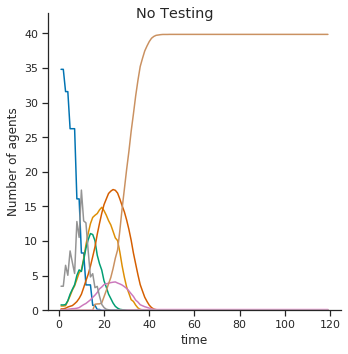

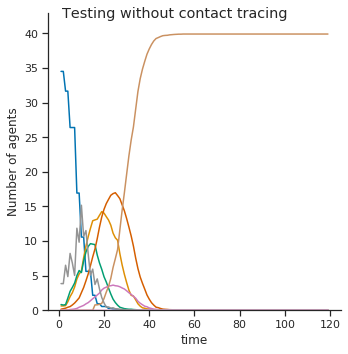

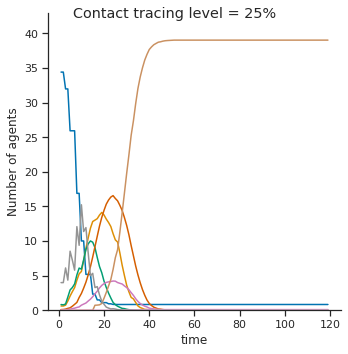

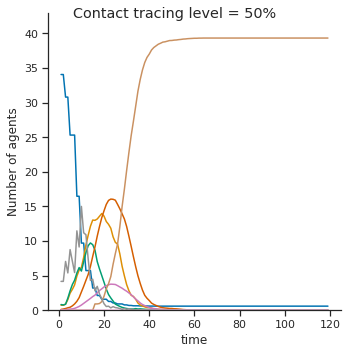

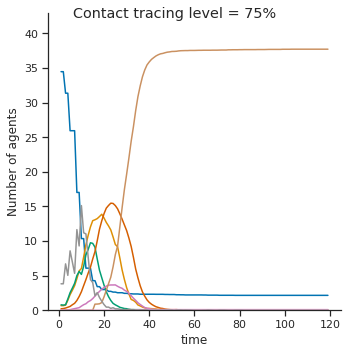

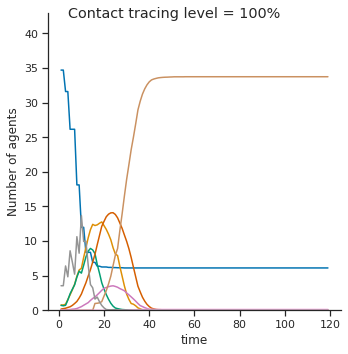

In [264]:
fig, axes = plt.subplots(6, 1)

r1 = sns.relplot(x="time", y="Number of agents", hue='HEALTH_STATUS', data=Test_and_trace_based_classroom_logs_melted[0][3], kind = 'line', palette = 'colorblind', ax=axes[0], legend=False)
r2 = sns.relplot(x="time", y="Number of agents", hue='HEALTH_STATUS', data=Test_and_trace_based_classroom_logs_melted[1][3], kind = 'line', palette = 'colorblind', ax=axes[1], legend=False)
r3 = sns.relplot(x="time", y="Number of agents", hue='HEALTH_STATUS', data=Test_and_trace_based_classroom_logs_melted[2][3], kind = 'line', palette = 'colorblind', ax=axes[2], legend=False)
r4 = sns.relplot(x="time", y="Number of agents", hue='HEALTH_STATUS', data=Test_and_trace_based_classroom_logs_melted[3][3], kind = 'line', palette = 'colorblind', ax=axes[3], legend=False)
r5 = sns.relplot(x="time", y="Number of agents", hue='HEALTH_STATUS', data=Test_and_trace_based_classroom_logs_melted[4][3], kind = 'line', palette = 'colorblind', ax=axes[4], legend=False)
r6 = sns.relplot(x="time", y="Number of agents", hue='HEALTH_STATUS', data=Test_and_trace_based_classroom_logs_melted[5][3], kind = 'line', palette = 'colorblind', ax=axes[5], legend=False)

r1.fig.suptitle(models[0])
r2.fig.suptitle(models[1])
r3.fig.suptitle(models[2])
r4.fig.suptitle(models[3])
r5.fig.suptitle(models[4])
r6.fig.suptitle(models[5])

r1.set(ylim=(0,43))
r2.set(ylim=(0,43))
r3.set(ylim=(0,43))
r4.set(ylim=(0,43))
r5.set(ylim=(0,43))
r6.set(ylim=(0,43))

r1.savefig('plot6-1.jpg', orientation="landscape",
           dpi=300)
r2.savefig('plot6-2.jpg', orientation="landscape",
           dpi=300)
r3.savefig('plot6-3.jpg', orientation="landscape",
           dpi=300)
r4.savefig('plot6-4.jpg', orientation="landscape",
           dpi=300)
r5.savefig('plot6-5.jpg', orientation="landscape",
           dpi=300)
r6.savefig('plot6-6.jpg', orientation="landscape",
           dpi=300)
           
plt.close(1)

#, height=8.27, aspect=11.7/8.27

## Now, playing with d and IVRR

### d (1 to 20 ft)

In [145]:
d_range = np.arange(1, 20, 1)/3.28084
 
item = Schedule_list[3]

d_MEAN_TRADITIONAL_RISKS = []
d_MEAN_MEAN_PROPOSED_RISK = []
d_MEAN_MAX_PROPOSED_RISK = []
d_MEAN_MEDIAN_PROPOSED_RISK = []
d_MEAN_MIN_PROPOSED_RISK = []
d_MEAN_MAX_PROPOSED_RISK = []

d_STUDENTS_FINAL = []
d_TEACHER_FINAL = []

d_CLASS_ROOMS_LIST = []

for d in list(d_range):
    
    schedule = item[0]
    final_duration = item[-1]
    
    STUDENTS_FINAL = []
    TEACHER_FINAL = []

    CLASS_ROOMS_LIST = []
    MEAN_TRADITIONAL_RISKS = []
    MEAN_PROPOSED_RISK = []
    MEDIAN_PROPOSED_RISK = []
    MIN_PROPOSED_RISK = []
    MAX_PROPOSED_RISK = []

    for i in range(sim_count):

        students = Agent().create_students(prevalence_rate, n)
        teacher = Agent().create_teacher()
        quanta_proportion = Quanta_Cone(d, r, h, concentration_rate, itter_count).get_individual_quanta_proportion()
        
        traditional_risks = []
        mean_proposed_risk = []
        median_proposed_risk = []
        min_proposed_risk = []
        max_proposed_risk = []

        classroom_log = pd.DataFrame({'time': [], 'Healthy' : [], 'Exposed' : [],'Asymptomatic' : [], 'Pre_symptomatic' : [],  'Mildly_symptomatic' : [],  'Symptomatic' : [],  'Immune' : [],  'Deceased' : [], 'Teacher': []})
        
        for time in range(1,120):
            
            [classroom_grid, classroom_scheme] = Classroom(students, teacher, rows, columns, prevalence_rate).get_classroom()
            covid19_spread_model = Covid19_Spread(students, teacher, classroom_grid, quanta_proportion, d, ERq, IVRR, IR, n0, T, classroom_height, final_duration)
            replication = Simulation(students, teacher, classroom_grid, covid19_spread_model, time)
            
            if time in schedule: #simulate for 90 days = the course of the semester
                replication.simulate_one_session_of_the_class() #this, will add students log automatically
                
                a = covid19_spread_model.get_final_Wells_Riley_risk()
                if len(list(a[np.nonzero(a)])) == 0: 
                    mean_proposed_risk.append(0)
                    median_proposed_risk.append(0)
                    min_proposed_risk.append(0)
                    max_proposed_risk.append(0)
                else:
                    mean_proposed_risk.append(np.mean(a[np.nonzero(a)]))
                    median_proposed_risk.append(np.median(a[np.nonzero(a)]))
                    min_proposed_risk.append(np.min(a[np.nonzero(a)]))
                    max_proposed_risk.append(np.max(a[np.nonzero(a)]))
                
                traditional_risks.append(traditional_Wells_Riley_risk(classroom_grid, rows, columns, d, classroom_height, ERq, IVRR, n0, final_duration)[-1]) 
                
            else: # if there is no class on that day, just update everything!
                for s in students: #Here, we update students log manually
                    s.add_agent_health_log(time)
                teacher.add_agent_health_log(time)
                #we do not test the teachers YET!

            #print(classroom_scheme)
            #print('\n')
            classroom_log = classroom_log.append(replication.get_classroom_summary(time), ignore_index=True)
                
                
        MEAN_TRADITIONAL_RISKS.append(traditional_risks)
        MEAN_PROPOSED_RISK.append(mean_proposed_risk)
        MEDIAN_PROPOSED_RISK.append(median_proposed_risk)
        MIN_PROPOSED_RISK.append(min_proposed_risk)
        MAX_PROPOSED_RISK.append(max_proposed_risk)
                
        CLASS_ROOMS_LIST.append(classroom_log)
      
        ss_total = []
        for student in students:      
            ss_total.append(student)
        STUDENTS_FINAL.append(ss_total)
        TEACHER_FINAL.append(teacher)
    
    d_MEAN_TRADITIONAL_RISKS.append(MEAN_TRADITIONAL_RISKS)
    d_MEAN_MEAN_PROPOSED_RISK.append(MEAN_PROPOSED_RISK)
    d_MEAN_MEDIAN_PROPOSED_RISK.append(MEDIAN_PROPOSED_RISK)
    d_MEAN_MIN_PROPOSED_RISK.append(MIN_PROPOSED_RISK)
    d_MEAN_MAX_PROPOSED_RISK.append(MAX_PROPOSED_RISK)
    
    d_STUDENTS_FINAL.append(STUDENTS_FINAL)
    d_TEACHER_FINAL.append(TEACHER_FINAL)

    d_CLASS_ROOMS_LIST.append(CLASS_ROOMS_LIST)
    

/opt/conda/lib/python3.7/site-packages/pandas/core/ops/array_ops.py:253: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  res_values = method(rvalues)


In [146]:
with open("d_MEAN_MEAN_PROPOSED_RISK.txt", "wb") as fp:   #Pickling
    pickle.dump(d_MEAN_MEAN_PROPOSED_RISK, fp)

In [ ]:
# Creating the dataset

x = [] 
y = []

k = 0
for i in range(19):
    k = i + 1
    y = y + d_MEAN_TRADITIONAL_RISKS[i] + d_MEAN_MAX_PROPOSED_RISK[i] + d_MEAN_MEAN_PROPOSED_RISK[i]
k = 0
for i in range(19):
    k = i + 1
    x = x + [k for j in range(sim_count*3)] 
z = (['Traditional model' for i in d_range] + ['Proposed model - Max' for i in d_range] + ['Proposed model - Mean' for i in d_range]) * sim_count 

distance_based_data = pd.DataFrame({'d': x, 'Estimated risk' : y, 'Model type' : z})

distance_based_data = distance_based_data.reset_index()
distance_based_data = distance_based_data.drop(columns=distance_based_data.columns[0])

distance_based_data_no_list = distance_based_data
for i in range(len(list(distance_based_data['Estimated risk']))):
    distance_based_data_no_list['Estimated risk'][i] = np.mean(distance_based_data['Estimated risk'][i])
    
distance_based_data_no_list['Estimated risk'] = pd.to_numeric(distance_based_data_no_list['Estimated risk'])
zzz = distance_based_data_no_list[distance_based_data_no_list['Model type'] == 'Traditional model']
distance_based_data_no_list['Estimated risk'] = pd.to_numeric(distance_based_data_no_list['Estimated risk'])

In [ ]:
sns.set()
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.lineplot(x = 'd', y = 'Estimated risk', data = distance_based_data_no_list, palette=["darkgoldenrod", "darkgreen", "green"], hue = "Model type" )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


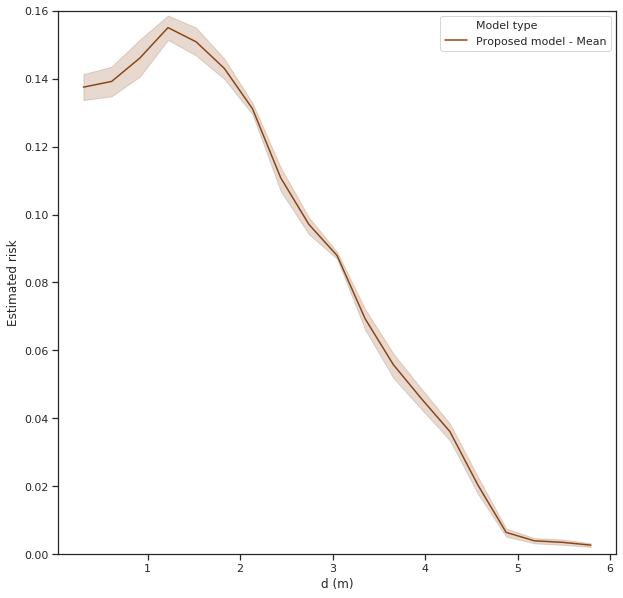

In [248]:
# Creating the dataset

x = [] 
y = []

k = 0
for i in range(19):
    k = i + 1
    y = y + d_MEAN_MEAN_PROPOSED_RISK[i]
k = 0
for i in range(19):
    k = i + 1
    x = x + [k/3.28084 for j in range(sim_count)] 
z = ( ['Proposed model - Mean' for i in d_range]) * sim_count 

distance_based_data = pd.DataFrame({'d (m)': x, 'Estimated risk' : y, 'Model type' : z})

distance_based_data = distance_based_data.reset_index()
distance_based_data = distance_based_data.drop(columns=distance_based_data.columns[0])

distance_based_data_no_list = distance_based_data
for i in range(len(list(distance_based_data['Estimated risk']))):
    distance_based_data_no_list['Estimated risk'][i] = np.mean(distance_based_data['Estimated risk'][i])
    
distance_based_data_no_list['Estimated risk'] = pd.to_numeric(distance_based_data_no_list['Estimated risk'])
zzz = distance_based_data_no_list[distance_based_data_no_list['Model type'] == 'Traditional model']
distance_based_data_no_list['Estimated risk'] = pd.to_numeric(distance_based_data_no_list['Estimated risk'])

#plot
sns.set()
sns.set(rc={'figure.figsize':(10,10)})
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
g=sns.lineplot(x = 'd (m)' , y = 'Estimated risk', data = distance_based_data_no_list, palette=["saddlebrown"], hue = "Model type" )
g.set(ylim=(0, 0.16))
plt.savefig('plot5-1.jpg', orientation="landscape",
           dpi=300)

### IVRR (1 to 2.5  h-1)

In [ ]:
d = 6/3.28084

IVRR_range = np.arange(1, 2.5, 0.25) 
 
item = Schedule_list[3]

IVRR_MEAN_TRADITIONAL_RISKS = []
IVRR_MEAN_MAX_PROPOSED_RISK = []
IVRR_MEAN_MEAN_PROPOSED_RISK = []
IVRR_MEAN_MEDIAN_PROPOSED_RISK = []
IVRR_MEAN_MIN_PROPOSED_RISK = []
IVRR_MEAN_MAX_PROPOSED_RISK = []

IVRR_STUDENTS_FINAL = []
IVRR_TEACHER_FINAL = []

IVRR_CLASS_ROOMS_LIST = []

for IVRR in list(IVRR_range):
    
    schedule = item[0]
    final_duration = item[-1]
    
    STUDENTS_FINAL = []
    TEACHER_FINAL = []

    CLASS_ROOMS_LIST = []
    MEAN_TRADITIONAL_RISKS = []
    MEAN_PROPOSED_RISK = []
    MEDIAN_PROPOSED_RISK = []
    MIN_PROPOSED_RISK = []
    MAX_PROPOSED_RISK = []

    for i in range(sim_count):

        students = Agent().create_students(prevalence_rate, n)
        teacher = Agent().create_teacher()
        quanta_proportion = Quanta_Cone(d, r, h, concentration_rate, itter_count).get_individual_quanta_proportion()
        
        traditional_risks = []
        mean_proposed_risk = []
        median_proposed_risk = []
        min_proposed_risk = []
        max_proposed_risk = []

        classroom_log = pd.DataFrame({'time': [], 'Healthy' : [], 'Exposed' : [],'Asymptomatic' : [], 'Pre_symptomatic' : [],  'Mildly_symptomatic' : [],  'Symptomatic' : [],  'Immune' : [],  'Deceased' : [], 'Teacher': []})
        
        for time in range(1,120):
            
            [classroom_grid, classroom_scheme] = Classroom(students, teacher, rows, columns, prevalence_rate).get_classroom()
            covid19_spread_model = Covid19_Spread(students, teacher, classroom_grid, quanta_proportion, d, ERq, IVRR, IR, n0, T, classroom_height, final_duration)
            replication = Simulation(students, teacher, classroom_grid, covid19_spread_model, time)
            
            if time in schedule: #simulate for 90 days = the course of the semester
                replication.simulate_one_session_of_the_class() #this, will add students log automatically
                
                a = covid19_spread_model.get_final_Wells_Riley_risk()
                if len(list(a[np.nonzero(a)])) == 0: 
                    mean_proposed_risk.append(0)
                    median_proposed_risk.append(0)
                    min_proposed_risk.append(0)
                    max_proposed_risk.append(0)
                else:
                    mean_proposed_risk.append(np.mean(a[np.nonzero(a)]))
                    median_proposed_risk.append(np.median(a[np.nonzero(a)]))
                    min_proposed_risk.append(np.min(a[np.nonzero(a)]))
                    max_proposed_risk.append(np.max(a[np.nonzero(a)]))
                
                traditional_risks.append(traditional_Wells_Riley_risk(classroom_grid, rows, columns, d, classroom_height, ERq, IVRR, n0, final_duration)[-1]) 
                
            else: # if there is no class on that day, just update everything!
                for s in students: #Here, we update students log manually
                    s.add_agent_health_log(time)
                teacher.add_agent_health_log(time)
                #we do not test the teachers YET!

            #print(classroom_scheme)
            #print('\n')
            classroom_log = classroom_log.append(replication.get_classroom_summary(time), ignore_index=True)
                
                
        MEAN_TRADITIONAL_RISKS.append(traditional_risks)
        MEAN_PROPOSED_RISK.append(mean_proposed_risk)
        MEDIAN_PROPOSED_RISK.append(median_proposed_risk)
        MIN_PROPOSED_RISK.append(min_proposed_risk)
        MAX_PROPOSED_RISK.append(max_proposed_risk)
                
        CLASS_ROOMS_LIST.append(classroom_log)
      
        ss_total = []
        for student in students:      
            ss_total.append(student)
        STUDENTS_FINAL.append(ss_total)
        TEACHER_FINAL.append(teacher)
    
    IVRR_MEAN_TRADITIONAL_RISKS.append(MEAN_TRADITIONAL_RISKS)
    IVRR_MEAN_MEAN_PROPOSED_RISK.append(MEAN_PROPOSED_RISK)
    IVRR_MEAN_MEDIAN_PROPOSED_RISK.append(MEDIAN_PROPOSED_RISK)
    IVRR_MEAN_MIN_PROPOSED_RISK.append(MIN_PROPOSED_RISK)
    IVRR_MEAN_MAX_PROPOSED_RISK.append(MAX_PROPOSED_RISK)
    
    IVRR_STUDENTS_FINAL.append(STUDENTS_FINAL)
    IVRR_TEACHER_FINAL.append(TEACHER_FINAL)

    IVRR_CLASS_ROOMS_LIST.append(CLASS_ROOMS_LIST)

In [249]:
with open("IVRR_MEAN_MEAN_PROPOSED_RISK.txt", "wb") as fp:   #Pickling
    pickle.dump(IVRR_MEAN_MEAN_PROPOSED_RISK, fp)

In [ ]:
# Creating the dataset

x = [] 
y = []

k = 0
for i in range(6):
    k = i + 1
    y = y + IVRR_MEAN_TRADITIONAL_RISKS[i] + IVRR_MEAN_MAX_PROPOSED_RISK[i] + IVRR_MEAN_MEAN_PROPOSED_RISK[i]
i = 0
for k in IVRR_range:
    i = i + 1
    x = x + [k for j in range(sim_count*3)] 
z = (['Traditional model' for i in IVRR_range] + ['Proposed model - Max' for i in IVRR_range] + ['Proposed model - Mean' for i in IVRR_range]) * sim_count 

IVRR_based_data = pd.DataFrame({'IVRR': x, 'Estimated risk' : y, 'Model type' : z})

IVRR_based_data = IVRR_based_data.reset_index()
IVRR_based_data = IVRR_based_data.drop(columns=IVRR_based_data.columns[0])

IVRR_based_data_no_list = IVRR_based_data
for i in range(len(list(IVRR_based_data['Estimated risk']))):
    IVRR_based_data_no_list['Estimated risk'][i] = np.mean(IVRR_based_data['Estimated risk'][i])
    
IVRR_based_data_no_list['Estimated risk'] = pd.to_numeric(IVRR_based_data_no_list['Estimated risk'])

In [ ]:
sns.set()
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
sns.lineplot(x = 'IVRR', y = 'Estimated risk', data = IVRR_based_data_no_list, palette=["darkgoldenrod", "teal", 'darkslategray'] , hue = "Model type" )

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


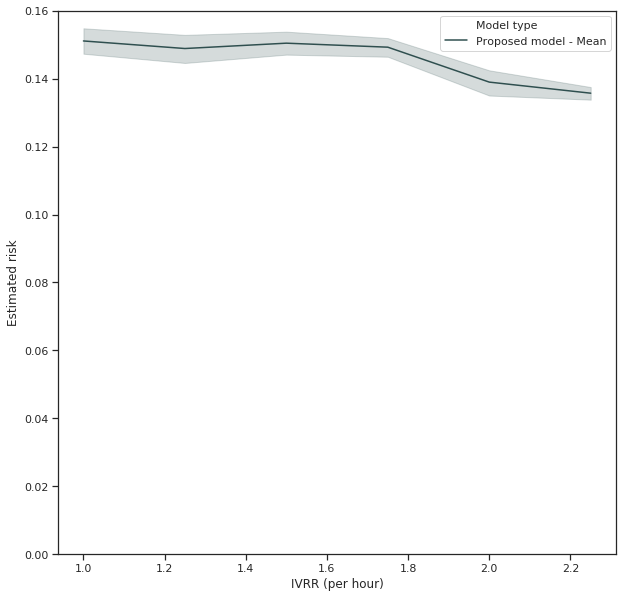

In [250]:
# Creating the dataset

x = [] 
y = []

k = 0
for i in range(6):
    k = i + 1
    y = y + IVRR_MEAN_MEAN_PROPOSED_RISK[i]
i = 0
for k in IVRR_range:
    i = i + 1
    x = x + [k for j in range(sim_count)] 
    
z = (['Proposed model - Mean' for i in IVRR_range]) * sim_count 

IVRR_based_data = pd.DataFrame({'IVRR (per hour)': x, 'Estimated risk' : y, 'Model type' : z})

IVRR_based_data = IVRR_based_data.reset_index()
IVRR_based_data = IVRR_based_data.drop(columns=IVRR_based_data.columns[0])

IVRR_based_data_no_list = IVRR_based_data
for i in range(len(list(IVRR_based_data['Estimated risk']))):
    IVRR_based_data_no_list['Estimated risk'][i] = np.mean(IVRR_based_data['Estimated risk'][i])
    
IVRR_based_data_no_list['Estimated risk'] = pd.to_numeric(IVRR_based_data_no_list['Estimated risk'])

sns.set()
sns.set_style("whitegrid")
sns.set_style("ticks", {"xtick.major.size": 8, "ytick.major.size": 8})
g = sns.lineplot(x = 'IVRR (per hour)', y = 'Estimated risk', data = IVRR_based_data_no_list, palette=['darkslategray'] , hue = "Model type" )
g.set(ylim=(0, 0.16))
plt.savefig('plot5-2.jpg', orientation="landscape",
           dpi=300)

## For further information please contact rzz5164@psu.edu